
# 중고차 데이터 EDA 
# 중고가에 영향을 미치는 요인 분석


* 중고차 매매 사이트를 크롤링하여 데이터를 수집 후 정제 및 가공
* 중고차에 가격에 영향을 미치는 요인들을 분석 및 시각화
* 팀원 : 김경수, 서완혁, 모시원

## 웹 크롤링

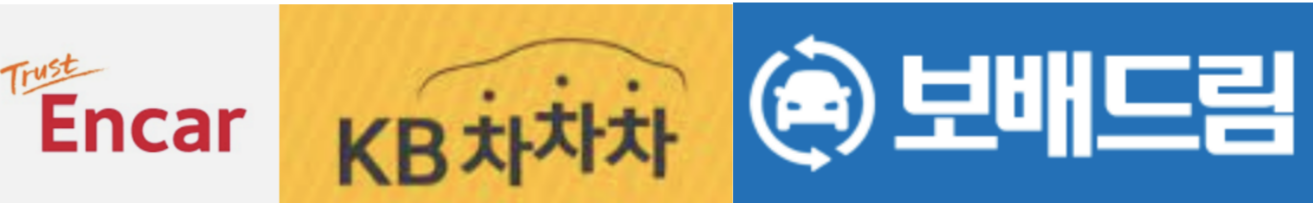
* 엔카 등록된 중고차 수 : 14만 대
* KB 차차차 등록된 중고차 수 : 13만 대
* 보배드림 등록된 중고차 수 : 6만 대

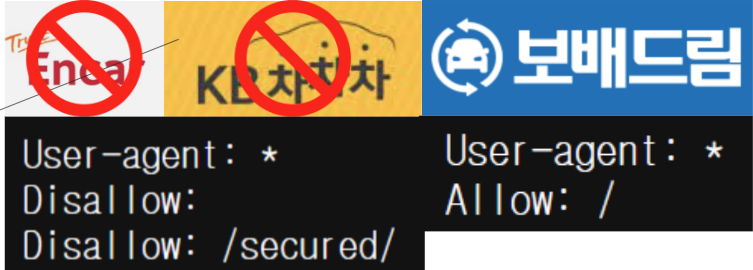
* 엔카와 KB차차차는 크롤링 진행 중 IP차단으로 인하여 진행 불가로 보배드림으로 진행

### 보배드림 크롤링 진행 방식
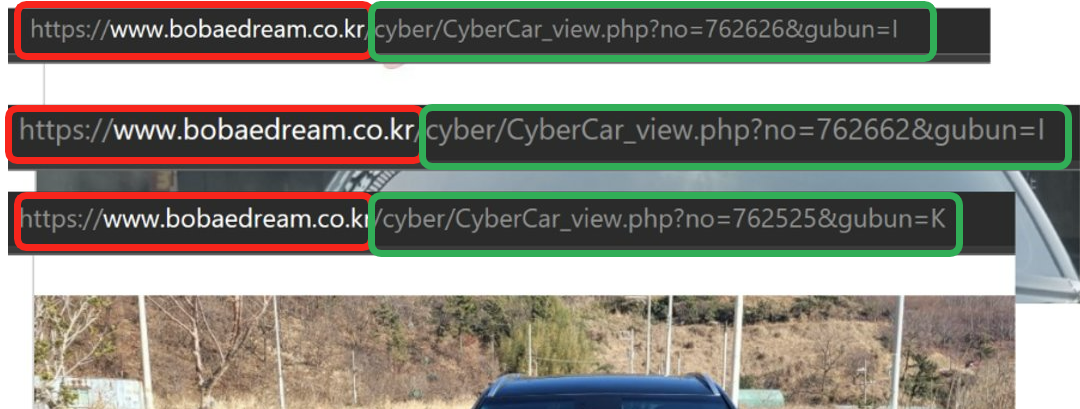
* 'https://www.bobaedream.co.kr' + 'href' 방식으로 상품의 상세정보 확인 가능
* 상품의 상세정보 페이지의 url을 수집하고 url을 통해 상세정보 수집

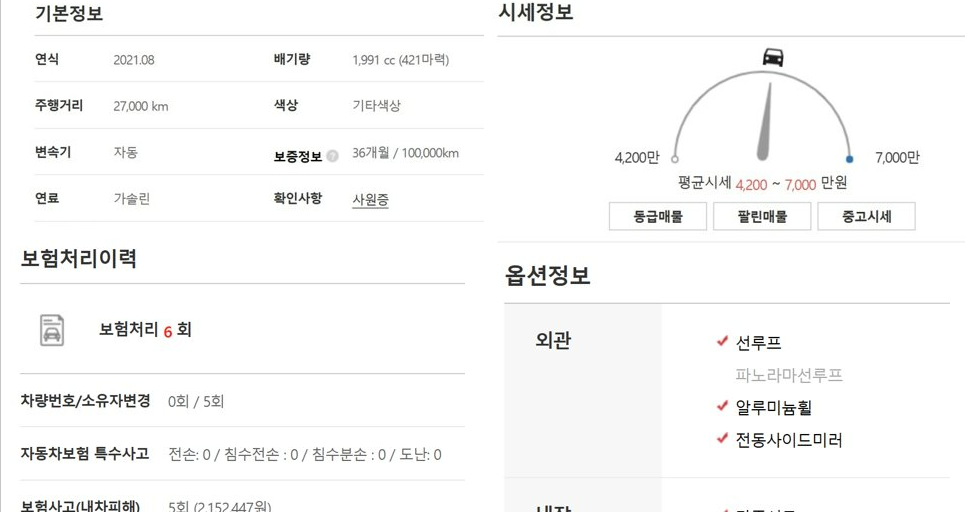
* 수집파일 데이터: 브랜드, 이름, 연식, 주행거리, 연료, 가격, 시세평균가, 배기량, 색상, 옵션, 보험료

데이터 프레임 보여주고 상위 10개 보여주고 국산/수입의 퍼센트 보여주고를 확인해보았다.

## 데이터 분석

In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver import ActionChains
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
from urllib.request import urlopen
from urllib import request
import requests
import pandas as pd
import numpy as np
import time
import pickle
import re
import seaborn as sns
import itertools

## matplotlib 경고 메시지 무시
import warnings
warnings.filterwarnings(action='ignore')

## 한글 폰트 설정
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'


## 23938 33 국산/수입1 제조사5 페이지203 차량 쿠퍼 컨트리맨 1.5 하이트림 f 브랜드: 미니
## 28925    국산/수입1 제조사63 페이지417 차량 718 카이맨 4.0 GT4 f 브랜드: ㅍㄽ

In [3]:
## 리스트 3개 불러오기 (car_list_1, car_list_2, car_list_3) 불러와서 데이터프레임으로 합치기

    
with open('/home/siwon/Documents/amr_ws/data_analysis/source_code/teamproject/car_list.pickle', 'rb') as f:
    car_list_3 = pickle.load(f) # 단 한줄씩 읽어옴
    
car_list= car_list_3

print("car_list   개수" + str(len(car_list)) + " 개, ")

## 데이터프레임으로 변환
df_car = pd.DataFrame(car_list, columns=['brand', 'name', 'year', 'distance', 'fuel', 'price', 'avg', 'cc', 'coWlor', 'option', 'insurance'])
df_car.head()
len(car_list)


car_list   개수29729 개, 


29729

In [279]:
df_car.tail(3)

brand                  name        year distance  fuel     price  \
29726  [기타]  [수입차 캠핑 트레일러 - -   ]  [18년 00월식]   [0 km]  [기타]    [[만료]]   
29727  [기타]  [수입차 캠핑 트레일러 - -   ]  [17년 00월식]   [0 km]  [기타]    [[만료]]   
29728  [기타]  [수입차 캠핑 트레일러 - -   ]  [14년 11월식]   [0 km]  [기타]  [[판매완료]]   

                avg         cc  coWlor option insurance  
29726  [[nan, nan]]  [0 cc ()]  [베이지색]  [nan]     [nan]  
29727  [[nan, nan]]  [0 cc ()]  [베이지색]  [nan]     [nan]  
29728  [[nan, nan]]  [0 cc ()]    [흰색]  [nan]     [nan]

In [4]:
# car_list 로 데이터 프레임 만들기
df = pd.DataFrame(car_list)

## 데이터 프레임 컬럼 이름 변경 (브랜드, 이름, 연식, 주행거리, 연료, 가격, 평균기, 배기량, 색상, 옵션, 보험)
df.columns = ['brand', 'name', 'year', 'distance', 'fuel', 'price', 'avg', 'cc', 'color', 'option', 'insurance']
df.head(2)

brand                       name              year      distance  fuel  \
0  [현대]           [e-카운티 캠핑카 -   ]  [10년 12월 (11년형)]  [150,129 km]  [디젤]   
1  [현대]  [아이오닉6 롱레인지 AWD 프레스티지   ]  [22년 11월 (23년형)]    [4,400 km]  [전기]   

     price           avg                cc   color  \
0  [3,990]  [[nan, nan]]     [3,933 cc ()]  [흰색투톤]   
1  [5,200]  [[nan, nan]]  [111 cc (325마력)]    [흰색]   

                                              option insurance  
0  [[None, None, None, None, None, None, None, No...     [nan]  
1  [[true, None, true, true, None, true, None, tr...     [nan]

In [6]:
## 컬럼들(brand name year distance fuel price avg cc color option insurance)의 리스트를 문자열로 변환하기
df['brand'] = df['brand'].apply(lambda x: ' '.join(x))
df['name'] = df['name'].apply(lambda x: ' '.join(x))
df['year'] = df['year'].apply(lambda x: ' '.join(x))
df['distance'] = df['distance'].apply(lambda x: ' '.join(x))
df['fuel'] = df['fuel'].apply(lambda x: ' '.join(x))
df['price'] = df['price'].apply(lambda x: ' '.join(x))
#df['avg'] = df['avg'].apply(lambda x: ' '.join(x))
df['cc'] = df['cc'].apply(lambda x: ' '.join(x))
df['color'] = df['color'].apply(lambda x: ' '.join(x))
#df['option'] = df['option'].apply(lambda x: ' '.join(x))
#df['insurance'] = df['insurance'].apply(lambda x: ' '.join(x))



In [282]:
df.tail(3)

brand                name      year distance fuel   price           avg  \
29726    기타  수입차 캠핑 트레일러 - -     18년 00월식     0 km   기타    [만료]  [[nan, nan]]   
29727    기타  수입차 캠핑 트레일러 - -     17년 00월식     0 km   기타    [만료]  [[nan, nan]]   
29728    기타  수입차 캠핑 트레일러 - -     14년 11월식     0 km   기타  [판매완료]  [[nan, nan]]   

            cc color option insurance  
29726  0 cc ()  베이지색  [nan]     [nan]  
29727  0 cc ()  베이지색  [nan]     [nan]  
29728  0 cc ()    흰색  [nan]     [nan]

### 주행거리(distance) 데이터 가공하기

In [7]:
## distance의 mi가 포함되어있으면 1mi를 1.609344km로 변환하고 km가 포함되어있으면 km를 제거
for i in range(len(df)):
    if 'mi' in df['distance'][i]:
        df['distance'][i] = df['distance'][i].replace('mi', '')
        df['distance'][i] = df['distance'][i].replace(' ', '')
        df['distance'][i] = df['distance'][i].replace(',', '')
        df['distance'][i] = int(float(df['distance'][i]) * 1.609344)
    else:
        df['distance'][i] = df['distance'][i].replace('km', '')
        df['distance'][i] = df['distance'][i].replace(' ', '')
        df['distance'][i] = df['distance'][i].replace(',', '')
        df['distance'][i] = int(df['distance'][i])
        

## distance를 int로 변환
df['distance'] = df['distance'].apply(lambda x: int(x))

df.tail(10)

brand                name      year  distance fuel   price  \
29719    기타   수입차 캠핑 트레일러 - -    18년 05월식         0   기타    [만료]   
29720    기타      수입차 캠핑카 - -     16년 10월식     19859  가솔린  [판매완료]   
29721    기타      수입차 캠핑카 - -     17년 07월식      9441  가솔린  [판매완료]   
29722    기타  수입차 캠핑 트레일러 - -     18년 00월식         0   기타    [만료]   
29723    기타  수입차 캠핑 트레일러 - -     18년 00월식         0   기타    [만료]   
29724    기타  수입차 캠핑 트레일러 - -     18년 00월식         0   기타    [만료]   
29725    기타  수입차 캠핑 트레일러 - -     18년 00월식         0   기타    [만료]   
29726    기타  수입차 캠핑 트레일러 - -     18년 00월식         0   기타    [만료]   
29727    기타  수입차 캠핑 트레일러 - -     17년 00월식         0   기타    [만료]   
29728    기타  수입차 캠핑 트레일러 - -     14년 11월식         0   기타  [판매완료]   

                avg           cc color  \
29719  [[nan, nan]]      0 cc ()  기타색상   
29720  [[nan, nan]]  3,600 cc ()  은색투톤   
29721  [[nan, nan]]  3,600 cc ()  은색투톤   
29722  [[nan, nan]]      0 cc ()    흰색   
29723  [[nan, nan]]      0 cc ()    흰색   
29724  [[nan, nan]]      0 cc ()    흰색   
29725  [[nan, nan]]      0 cc ()  은색투톤   
29726  [[nan, nan]]      0 cc ()  베이지색   
29727  [[nan, nan]]      0 cc ()  베이지색   
29728  [[nan, nan]]      0 cc ()    흰색   

                                                  option  \
29719                                              [nan]   
29720  [[true, None, true, true, None, None, None, tr...   
29721  [[true, None, true, true, None, true, None, tr...   
29722  [[true, None, None, None, None, None, None, No...   
29723                                              [nan]   
29724                                              [nan]   
29725                                              [nan]   
29726                                              [nan]   
29727                                              [nan]   
29728                                              [nan]   

                                     insurance  
29719                                    [nan]  
29720  [0, 0, 0, 0, 0, 0, 0, 0, (0원), 0, (0원)]  
29721                                    [nan]  
29722                                    [nan]  
29723                                    [nan]  
29724                                    [nan]  
29725                                    [nan]  
29726                                    [nan]  
29727                                    [nan]  
29728                                    [nan]

### price 데이터 가공

In [8]:
## price에서 [판매완료], [계약] 이라고 적혀있는 데이터는 삭제
df = df[df['price'] != '[판매완료]']
df = df[df['price'] != '[계약]']
df = df[df['price'] != '[가격상담]']
df = df[df['price'] != '[만료]']
df = df[df['price'] != '[보류]']
## 인덱스 재정렬
df = df.reset_index(drop=True)

## price를 int로 변환
df['price'] = df['price'].apply(lambda x: int(x.replace(',', '')))


## price 중에 9999, 0, 99999 인 데이터 삭제
## price 중에 30000이 넘으면 삭제
df = df[df['price'] < 30000]
df = df[df['price'] != 9999]
df = df[df['price'] != 0]
df = df[df['price'] != 99999]
df = df[df['price'] != 999999]
df = df[df['price'] != 9999999]
df = df[df['price'] != 99999999]
df = df[df['price'] != 999999999]
df = df[df['price'] != 9999999999]

## 인덱스 재정렬
df = df.reset_index(drop=True)
df.tail(10)

brand               name            year  distance fuel  price  \
25368    기타  수입차 캠핑 트레일러 - -          17년 04월식         0   기타   5200   
25369    기타     수입차 캠핑카 - -     18년 05월 (14년형)     23000  가솔린  13000   
25370    기타     수입차 전기차 - -           18년 11월식     14370   전기    799   
25371    기타  수입차 캠핑 트레일러 - -          20년 11월식         0   기타   2450   
25372    기타     수입차 캠핑카 - -           20년 00월식       360  가솔린  15500   
25373    기타     수입차 캠핑카 - -           21년 00월식       500  가솔린  12997   
25374    기타     수입차 캠핑카 - -           22년 00월식      4658  가솔린  16800   
25375    기타  수입차 캠핑 트레일러 - -          22년 03월식         0   기타   8800   
25376    기타   수입차 캠핑 트레일러 - -         22년 00월식         0   기타   4890   
25377    기타  수입차 희소차량 올드카 -           86년 00월식    470036   디젤   2500   

                avg           cc color  \
25368  [[nan, nan]]      0 cc ()    흰색   
25369  [[nan, nan]]  6,751 cc ()  기타색상   
25370  [[nan, nan]]    120 cc ()   검정색   
25371  [[nan, nan]]      0 cc ()    흰색   
25372  [[nan, nan]]  3,600 cc ()    흰색   
25373  [[nan, nan]]  2,998 cc ()    흰색   
25374  [[nan, nan]]  3,500 cc ()  은색투톤   
25375  [[nan, nan]]      0 cc ()    흰색   
25376  [[nan, nan]]      0 cc ()    흰색   
25377  [[nan, nan]]  6,000 cc ()   하늘색   

                                                  option  \
25368                                              [nan]   
25369  [[None, None, None, None, None, None, None, No...   
25370  [[None, None, true, None, None, None, None, tr...   
25371                                              [nan]   
25372  [[true, None, true, None, None, None, None, No...   
25373                                              [nan]   
25374  [[true, None, true, true, None, None, None, No...   
25375  [[None, None, true, None, None, None, None, No...   
25376                                              [nan]   
25377                                              [nan]   

                                               insurance  
25368                                              [nan]  
25369                                              [nan]  
25370  [3, 0, 1, 0, 0, 0, 0, 1, (3,747,203원), 2, (870...  
25371                                              [nan]  
25372                                              [nan]  
25373                                              [nan]  
25374                                              [nan]  
25375                                              [nan]  
25376                                              [nan]  
25377                                              [nan]

#### 데이터 브랜드별 시각화

#### 브랜드 별 개수 

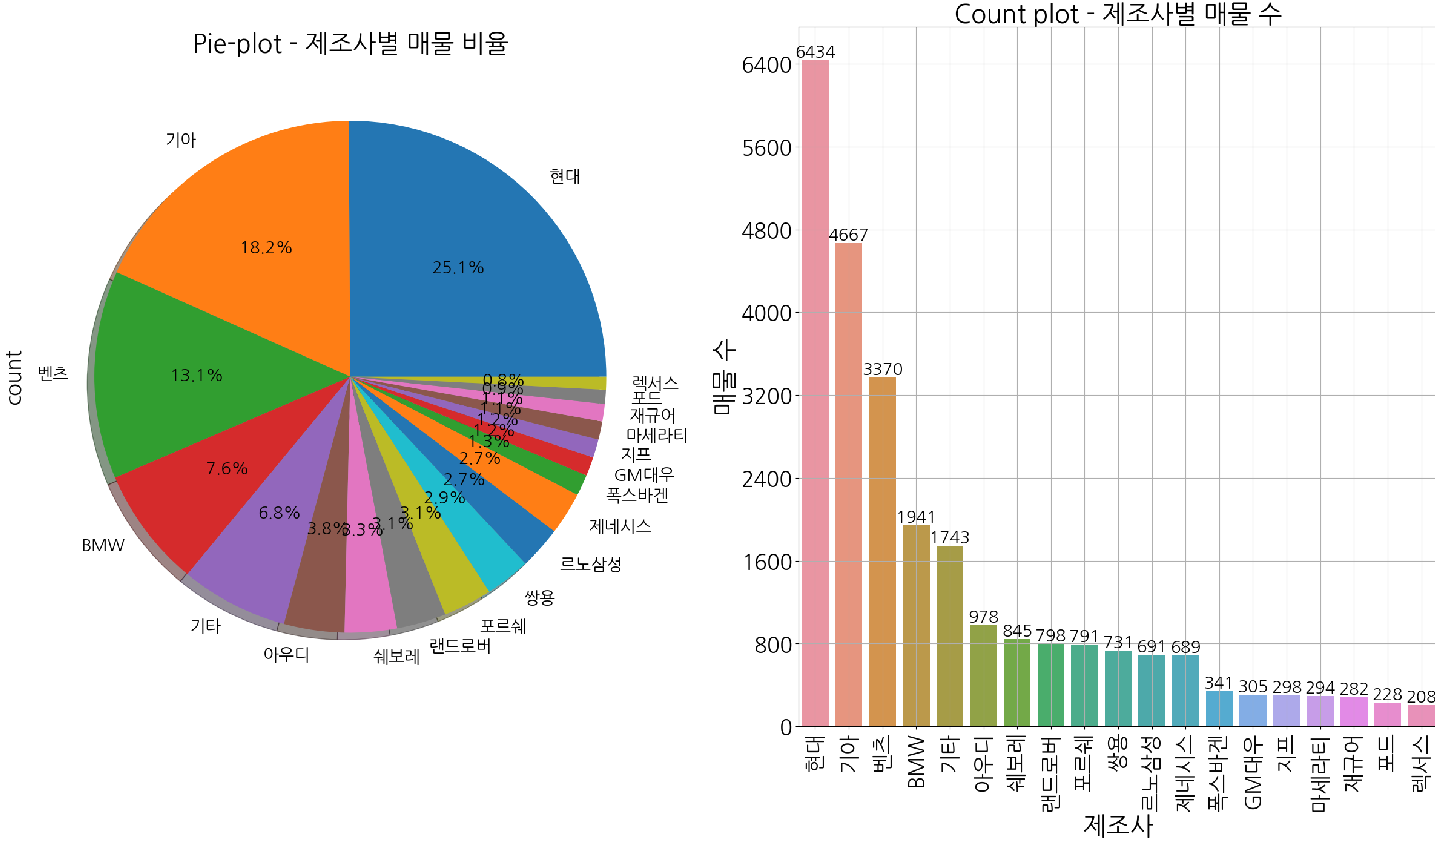

#### 국산/수입 비율 비교

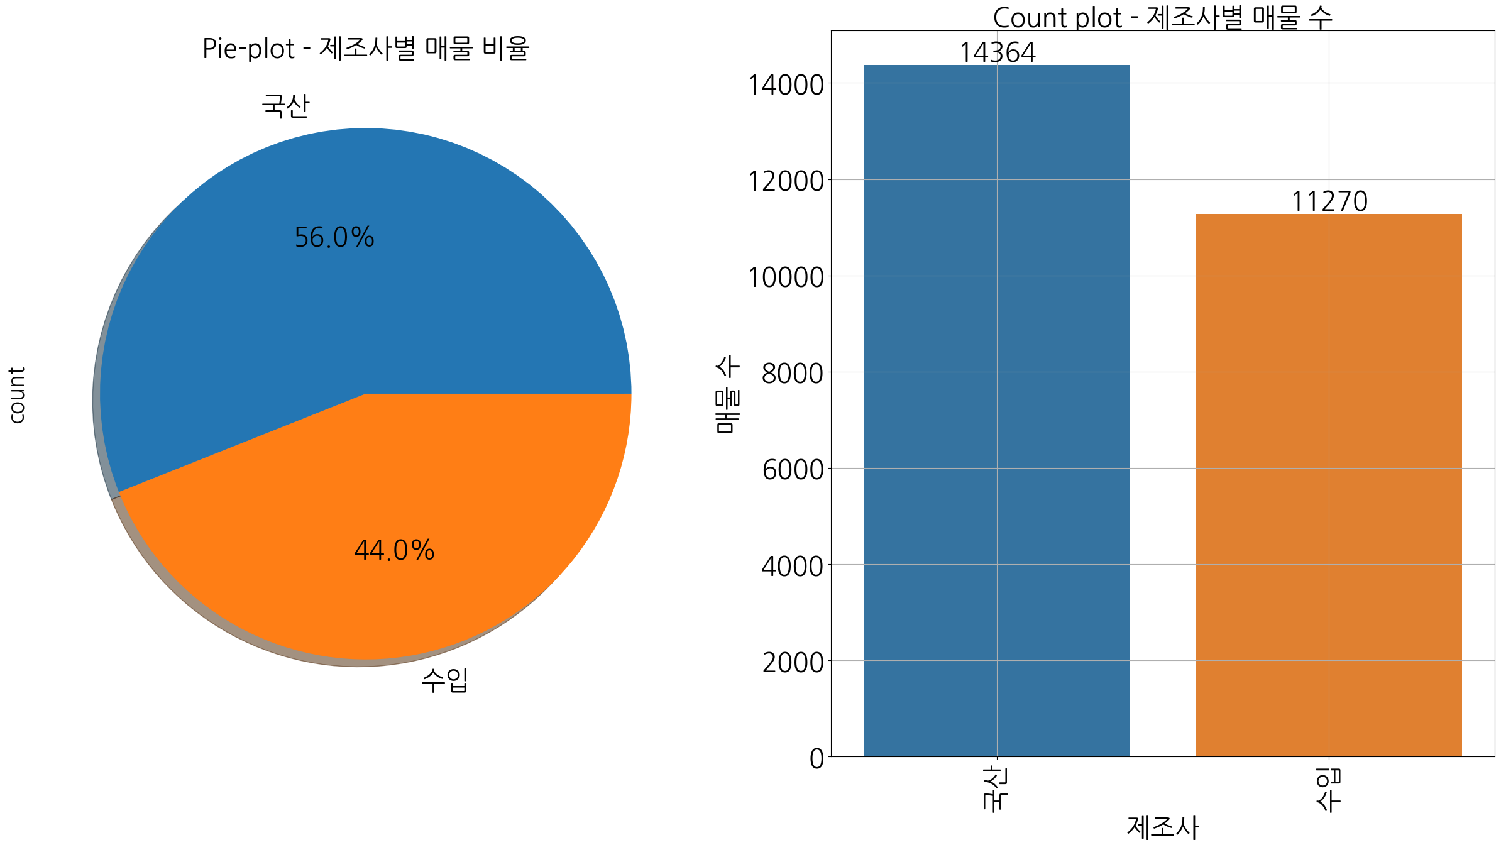

### 색상

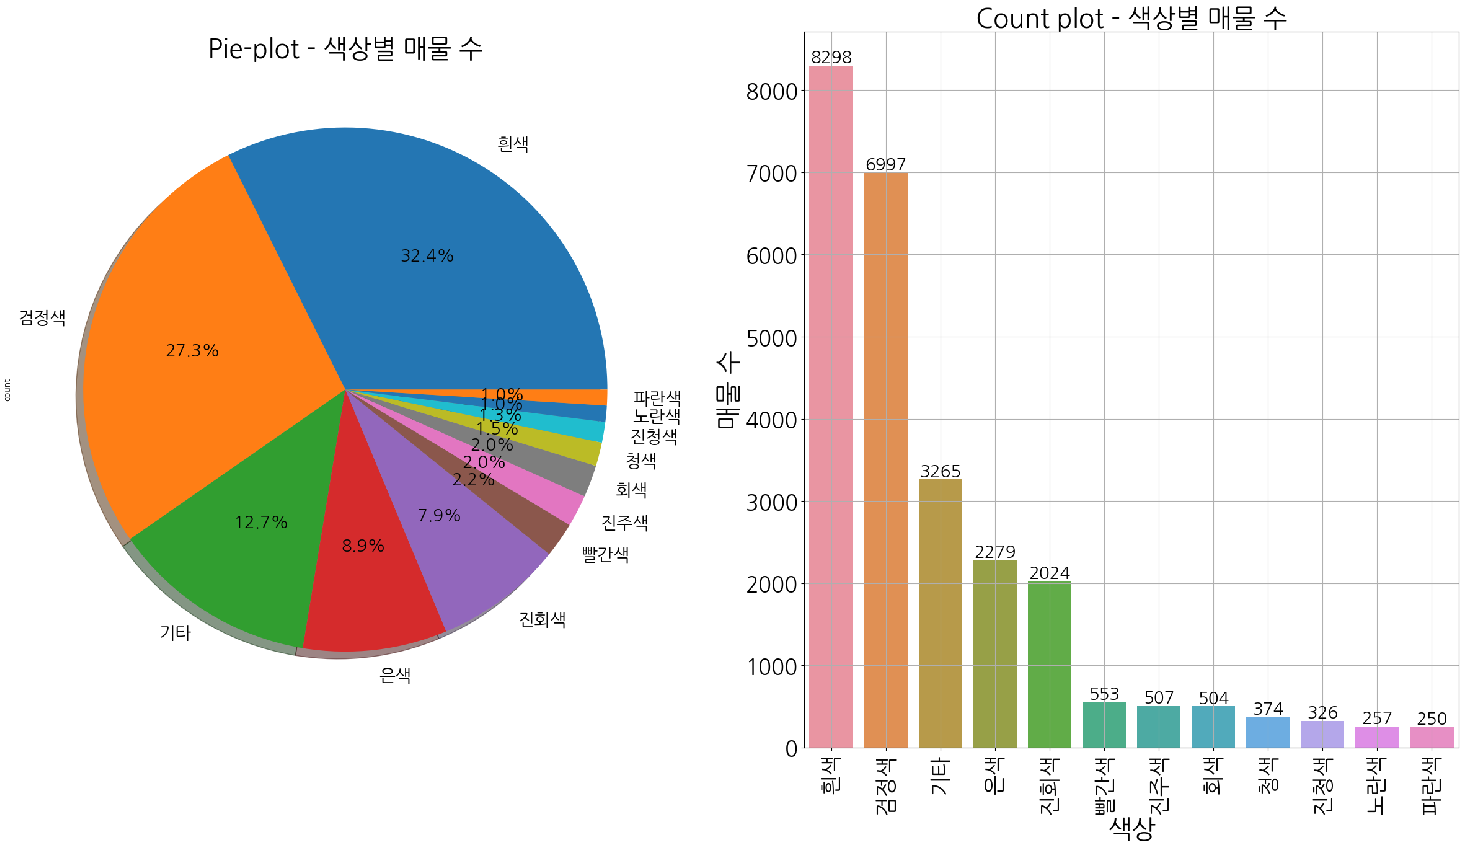

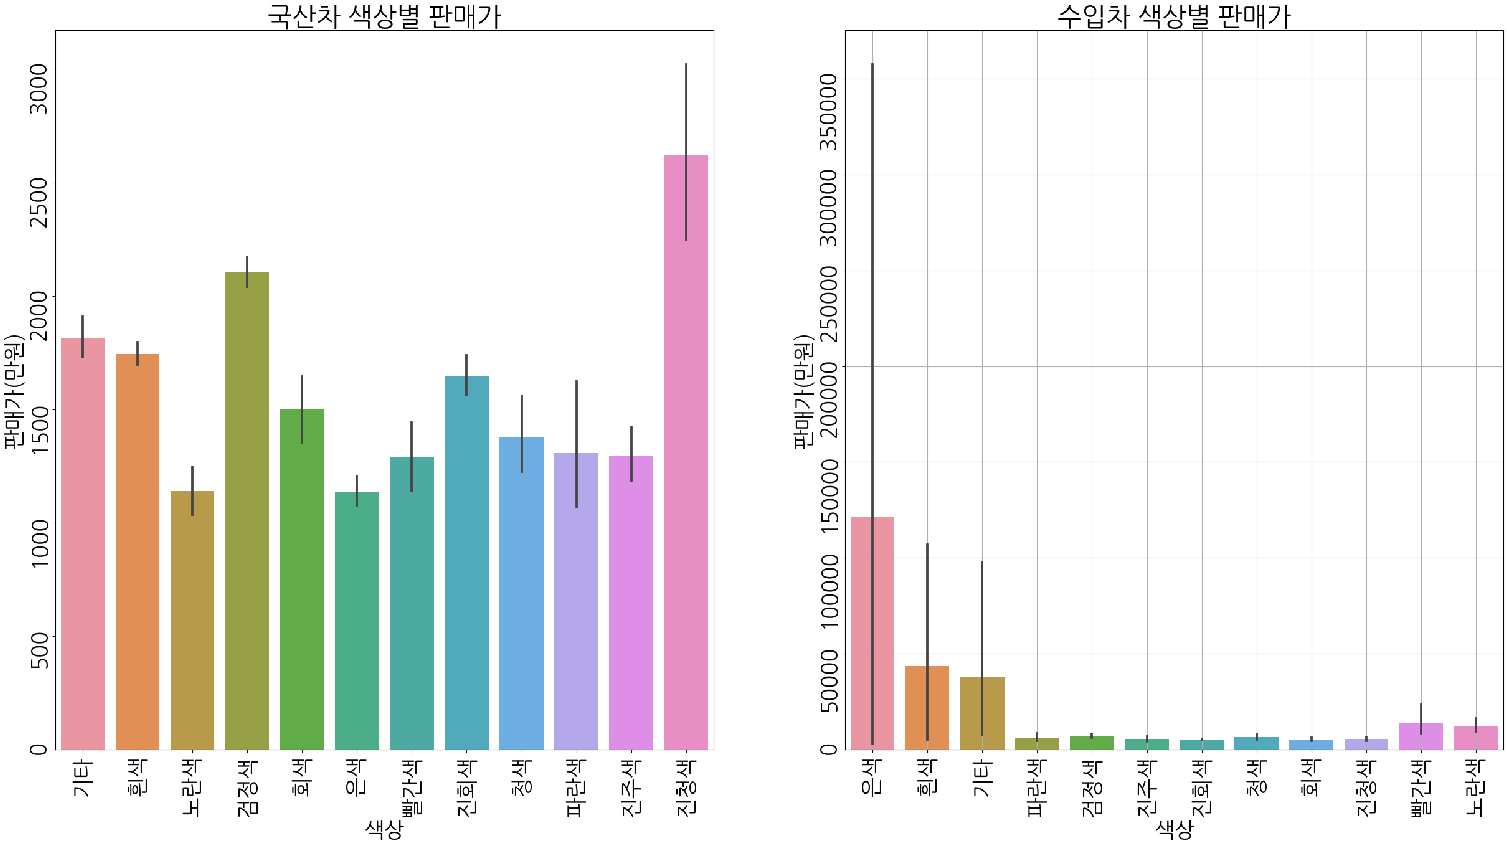

### 옵션

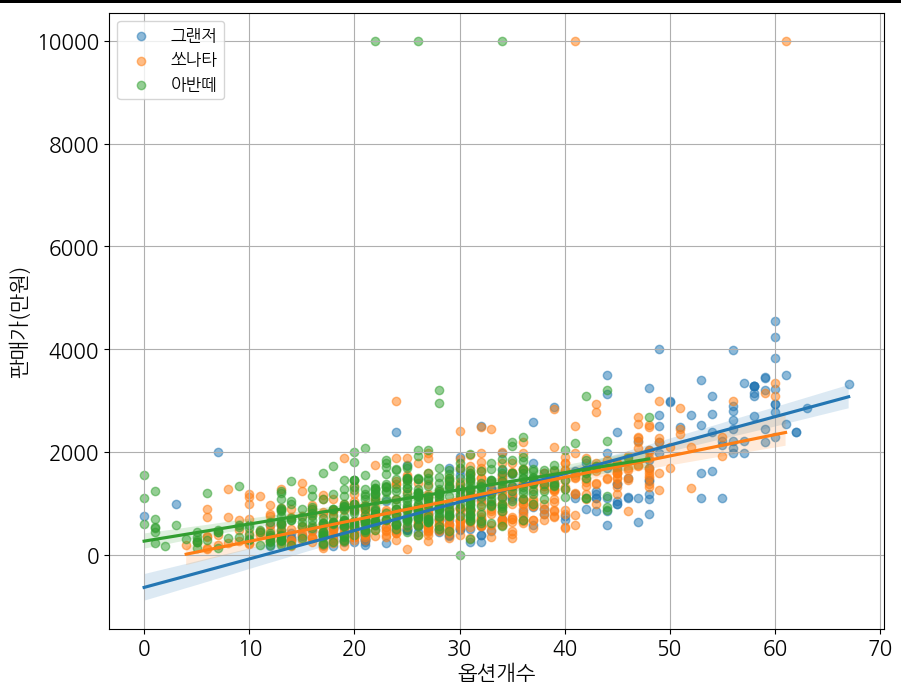

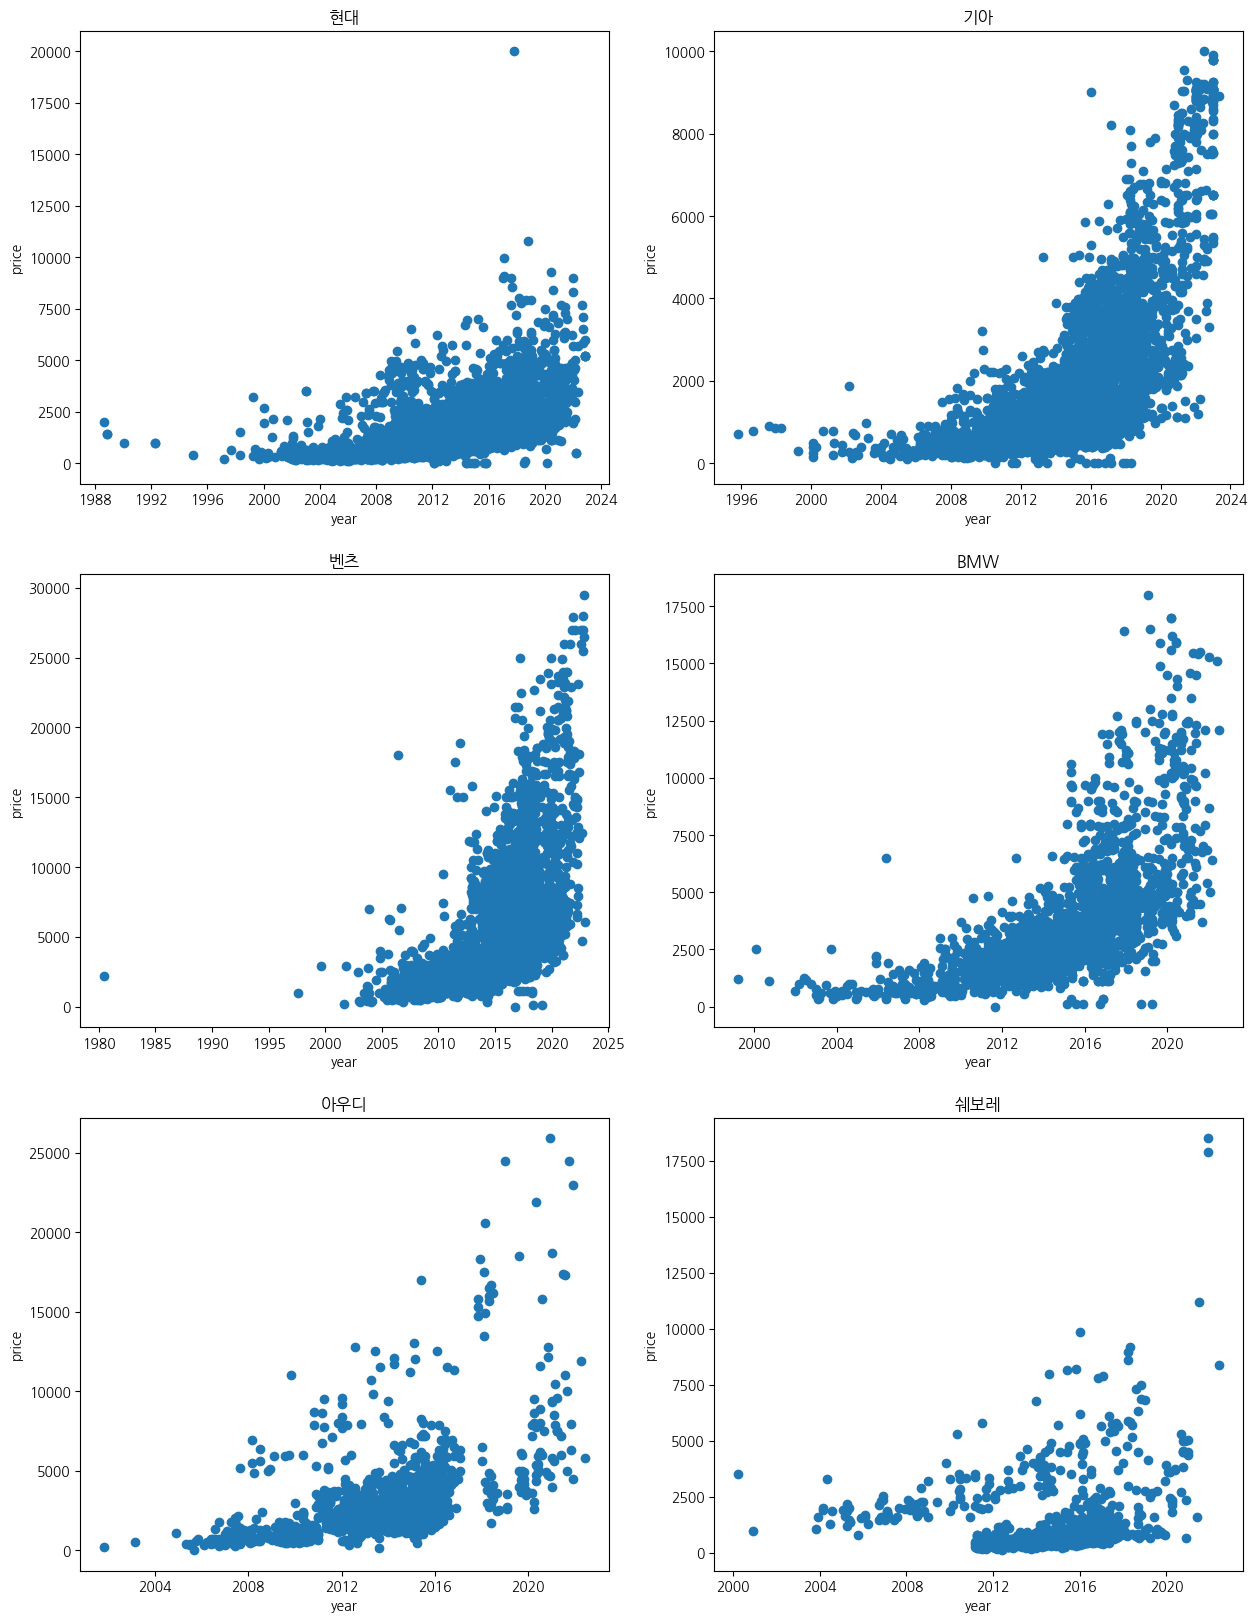

In [12]:
## 가격과 주행거리의 상관관계를 상위10개의 브랜드로 나누어서 시각화(subplot)
brand_list = df['brand'].value_counts().index[:6]
brand_list

fig, axes = plt.subplots(3, 2, figsize=(15, 20))
for i, brand in enumerate(brand_list):
    df_brand = df[df['brand'] == brand]
    axes[i//2, i%2].scatter(df_brand['year'], df_brand['price'])
    axes[i//2, i%2].set_title(brand)
    axes[i//2, i%2].set_xlabel('year')
    axes[i//2, i%2].set_ylabel('price')
plt.show()


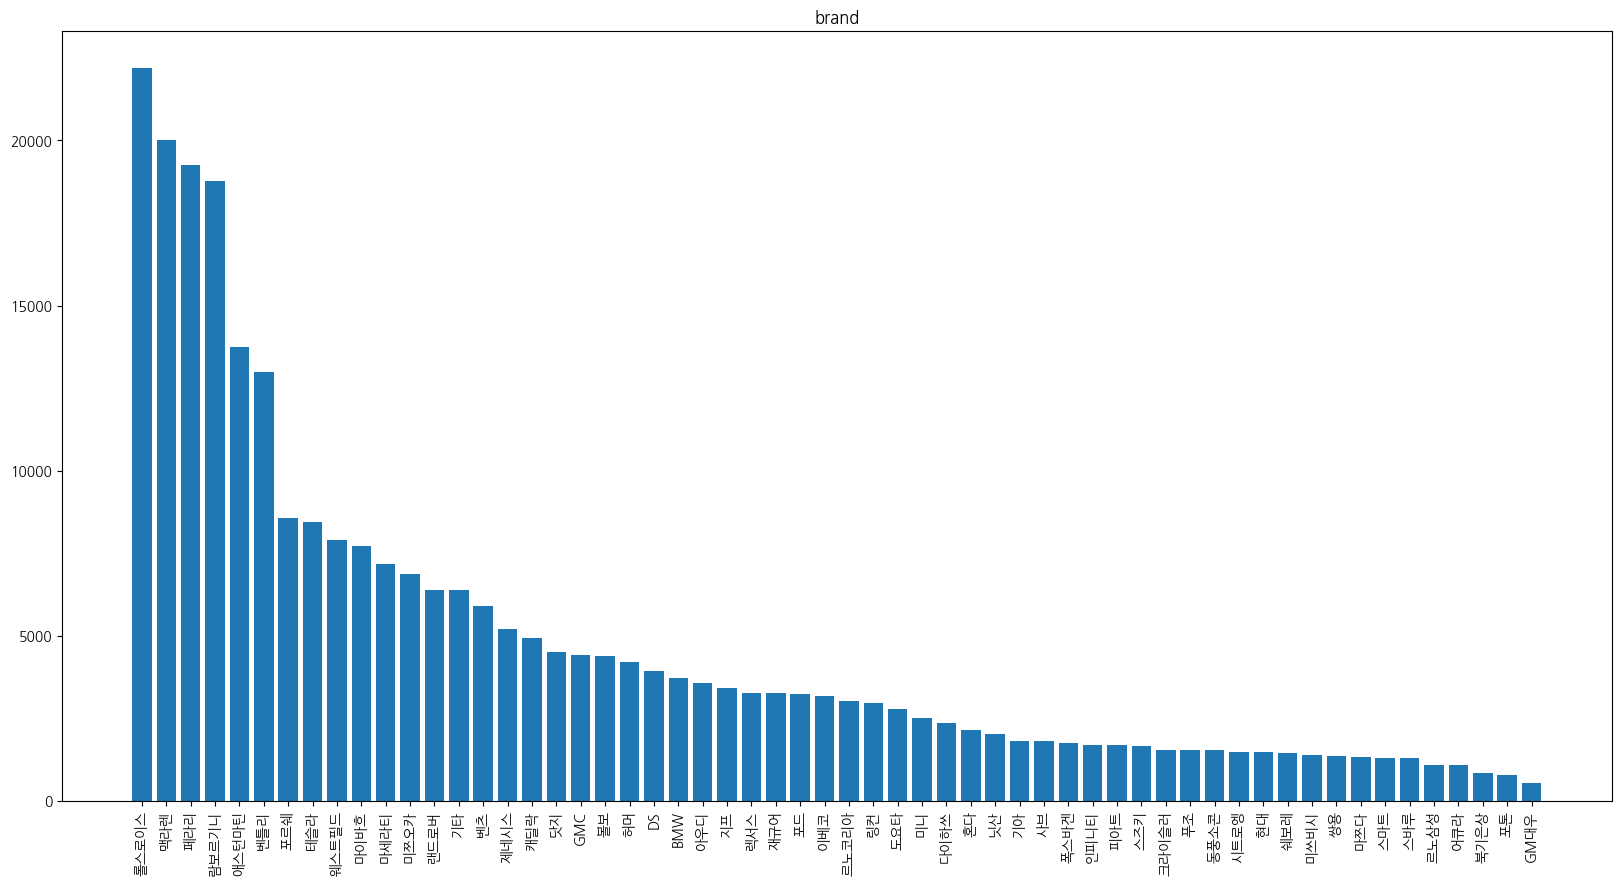

In [286]:
## 당연하지만 브랜드가 중고차 가격에 영향을 미칠까? 브랜드별 가격의 평균을 구하고 시각화
df_brand = df.groupby('brand')['price'].mean().sort_values(ascending=False)
df_brand

plt.figure(figsize=(20, 10))
plt.title('brand')
plt.bar(df_brand.index, df_brand)
plt.xticks(rotation=90)
plt.show()

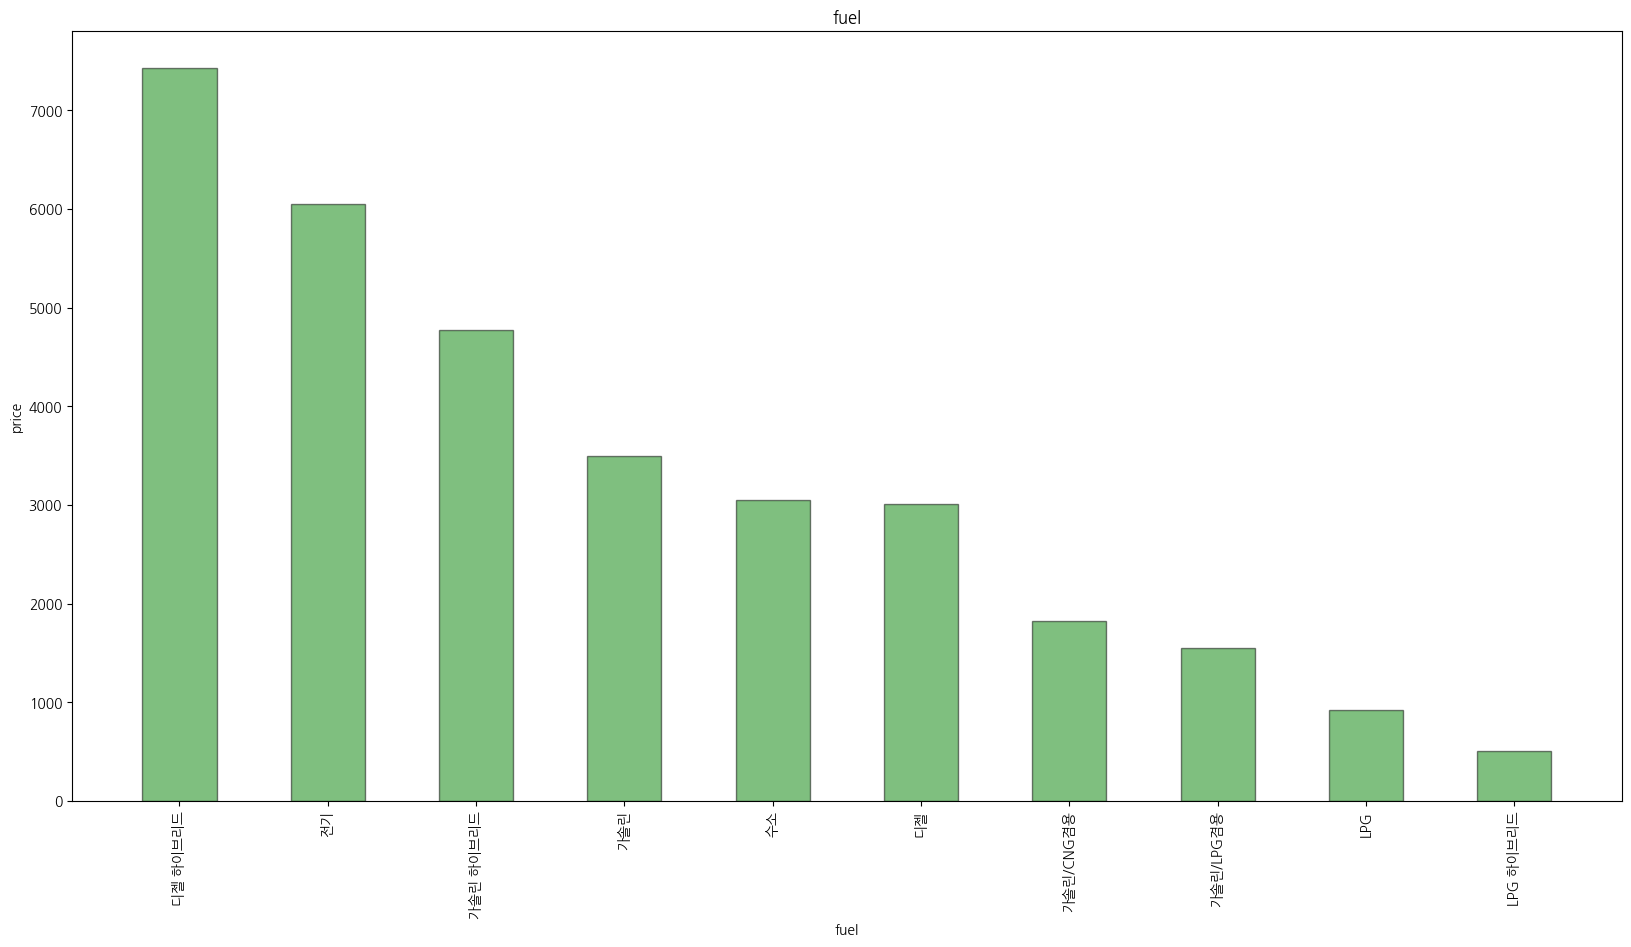

In [287]:
## 연료 중에 기타가 있으면 삭제
df = df[df['fuel'] != '기타']
df = df.reset_index(drop=True)
df.tail(10)

## 연료와 가격 시각화
df_fuel = df.groupby('fuel')['price'].mean().sort_values(ascending=False)
df_fuel

plt.figure(figsize=(20, 10))
plt.bar(df_fuel.index, df_fuel, color='green', alpha=0.5, width=0.5, label='fuel', align='center', edgecolor='black', linewidth=1)
plt.xlabel('fuel')
plt.ylabel('price')
plt.title('fuel')

plt.xticks(rotation=90)
plt.show()


## 보험 처리와 중고차의 관계

### 보험데이터 가공하기

In [288]:
## df 에서 brand, price, distance, fuel, insurance 컬럼만 추출
df_insurance = df[['brand', 'name','price', 'distance', 'insurance']]

## df_insurance["insurance"]를 모두 문자열로 변환
df_insurance['insurance'] = df_insurance['insurance'].apply(lambda x: str(x))


## df_insurance["insurance"] 중에서 [nan] 또는 [[nan]] 인 데이터 삭제
df_insurance = df_insurance[df_insurance['insurance'] != '[nan]']
df_insurance = df_insurance[df_insurance['insurance'] != '[[nan]]']


df_insurance = df_insurance.reset_index(drop=True)
df_insurance.head(2)

df_insurance.tail(10)

brand                        name  price  distance  \
4578    혼다              시빅 타입 R 2.0      4700     78985   
4579    혼다                   시빅 2.0       299    120000   
4580    혼다           올 뉴 오딧세이 3.5 -      3790     55000   
4581    혼다            시빅 2.0 Type-R      2800     15788   
4582    혼다             오딧세이 3.5 4세대      2350     56000   
4583    혼다         올 뉴 오딧세이 3.5 5세대      4700      4250   
4584    혼다  어코드 2.4 세단 EX-L CVT 9세대      2250     46500   
4585    혼다          파일럿 3.5 4WD 2세대      1990    103667   
4586    혼다           레전드 3.7 세단 4세대       950    128000   
4587    기타              수입차 전기차 - -       799     14370   

                                              insurance  
4578  ['0', '2', '2', '0', '0', '0', '0', '0', '(0원)...  
4579  ['10', '0', '3', '0', '0', '0', '0', '6', '(15...  
4580  ['0', '0', '0', '0', '0', '0', '0', '0', '(0원)...  
4581  ['0', '0', '2', '0', '0', '0', '0', '0', '(0원)...  
4582  ['0', '1', '6', '0', '0', '0', '0', '0', '(0원)...  
4583  ['0', '0', '0', '0', '0', '0', '0', '0', '(0원)...  
4584  ['3', '0', '1', '0', '0', '0', '0', '1', '(3,2...  
4585  ['4', '1', '4', '0', '0', '0', '0', '3', '(3,0...  
4586  ['9', '0', '1', '0', '0', '0', '0', '6', '(24,...  
4587  ['3', '0', '1', '0', '0', '0', '0', '1', '(3,7...

In [289]:

## 원 앞에 , 가 붙어있는 데이터가 있다. () 안에 있는 ,는 제거
df_insurance['insurance'] = df_insurance['insurance'].apply(lambda x: x.replace('(', '').replace(')', '').replace(',', ''))
df_insurance.head(2)

## df_insurance["insurance"]를 ''로 스플릿하고 한개씩 컬럼에 추가
df_insurance['insurance1'] = df_insurance['insurance'].apply(lambda x: x.split(' ')[0])
df_insurance['insurance2'] = df_insurance['insurance'].apply(lambda x: x.split(' ')[1])
df_insurance['insurance3'] = df_insurance['insurance'].apply(lambda x: x.split(' ')[2])
df_insurance['insurance4'] = df_insurance['insurance'].apply(lambda x: x.split(' ')[3])
df_insurance['insurance5'] = df_insurance['insurance'].apply(lambda x: x.split(' ')[4])
df_insurance['insurance6'] = df_insurance['insurance'].apply(lambda x: x.split(' ')[5])
df_insurance['insurance7'] = df_insurance['insurance'].apply(lambda x: x.split(' ')[6])
df_insurance['insurance8'] = df_insurance['insurance'].apply(lambda x: x.split(' ')[7])
df_insurance['insurance9'] = df_insurance['insurance'].apply(lambda x: x.split(' ')[8])
df_insurance['insurance10'] = df_insurance['insurance'].apply(lambda x: x.split(' ')[9])
df_insurance['insurance11'] = df_insurance['insurance'].apply(lambda x: x.split(' ')[10])

## 첫번째 컬럼 [ 제거
df_insurance['insurance1'] = df_insurance['insurance1'].apply(lambda x: x.split('[')[1])
## 마지막 컬럼 ]제거
df_insurance['insurance11'] = df_insurance['insurance11'].apply(lambda x: x.split(']')[0])


## df_insurance['insurance'] 컬럼 삭제
df_insurance = df_insurance.drop(['insurance'], axis=1)


## insurance9 와 insurance11 의 '원' 삭제 
df_insurance['insurance9'] = df_insurance['insurance9'].apply(lambda x: x.split('원')[0])
df_insurance['insurance11'] = df_insurance['insurance11'].apply(lambda x: x.split('원')[0])


    
## df_insurance['insurance'] 컬럼 모두 따옴표와 공백을 제거
df_insurance['insurance1'] = df_insurance['insurance1'].apply(lambda x: x.replace("'", '').replace(' ', ''))
df_insurance['insurance2'] = df_insurance['insurance2'].apply(lambda x: x.replace("'", '').replace(' ', ''))
df_insurance['insurance3'] = df_insurance['insurance3'].apply(lambda x: x.replace("'", '').replace(' ', ''))
df_insurance['insurance4'] = df_insurance['insurance4'].apply(lambda x: x.replace("'", '').replace(' ', ''))
df_insurance['insurance5'] = df_insurance['insurance5'].apply(lambda x: x.replace("'", '').replace(' ', ''))
df_insurance['insurance6'] = df_insurance['insurance6'].apply(lambda x: x.replace("'", '').replace(' ', ''))
df_insurance['insurance7'] = df_insurance['insurance7'].apply(lambda x: x.replace("'", '').replace(' ', ''))
df_insurance['insurance8'] = df_insurance['insurance8'].apply(lambda x: x.replace("'", '').replace(' ', ''))
df_insurance['insurance9'] = df_insurance['insurance9'].apply(lambda x: x.replace("'", '').replace(' ', ''))
df_insurance['insurance10'] = df_insurance['insurance10'].apply(lambda x: x.replace("'", '').replace(' ', ''))
df_insurance['insurance11'] = df_insurance['insurance11'].apply(lambda x: x.replace("'", '').replace(' ', ''))

## insurance1 이 공백이라면 0으로 변경
df_insurance['insurance1'] = df_insurance['insurance1'].apply(lambda x: x.replace('', '0'))

## df_insurance['insurance'] 컬럼 int로 변환(for문 사용)
for i in range(1, 12):
    df_insurance['insurance'+str(i)] = df_insurance['insurance'+str(i)].astype('int')
    
## df_insurance['insurance'] 컬럼 이름 변경
df_insurance = df_insurance.rename(columns={'insurance1':'보험처리수', 'insurance2':'차량번호변경', 'insurance3':'소유자변경', 'insurance4':'전손', 'insurance5':'침수전손', 'insurance6':'침수분손', 'insurance7':'도난', 'insurance8':'내차사고건수', 'insurance9':'내차피해금액', 'insurance10':'상대차피해건수', 'insurance11':'상대차피해금액'})

## 내차피해금액이랑 상대차피해금액이랑 합쳐서 새로운 컬럼 만들기
df_insurance['피해금액'] = df_insurance['내차피해금액'] + df_insurance['상대차피해금액']
## 피해금액이 0인경우는 삭제
df_insurance = df_insurance.reset_index(drop=True)
## 피해금액중에 10000000 이 넘어가면 삭제
df_insurance = df_insurance[df_insurance['피해금액'] < 10000000]
## 피해금액순으로 정렬
df_insurance = df_insurance.sort_values(by=['피해금액'], ascending=False)
df_insurance.tail(10)

brand                              name  price  distance  보험처리수  차량번호변경  \
1726   쉐보레                   임팔라 3.6 프리미어      2500     60440      0       0   
3156   BMW                       528i F10      3240     59900      0       0   
3155   BMW                    320d ED F30      3140     16600      0       0   
3154   BMW  7시리즈 740Li xDrive M 스포츠 팩 G12     12000      4200      0       0   
3153   BMW       7시리즈 750Li xDrive 비전 100     11900     18000      0       0   
3151   BMW                          i8 쿠페     11200      8300      0       0   
1730   쉐보레             크루즈 2.0 디젤 LTZ 플러스       580    148309      0       0   
1733   쉐보레              크루즈 2.0 디젤 LT 플러스       750     89379      0       1   
3147   BMW                         528i -       820    114341      0       0   
2517    벤츠      E300 4매틱 아방가르드 인텔리전트 드라이브      5450     29350      0       0   

      소유자변경  전손  침수전손  침수분손  도난  내차사고건수  내차피해금액  상대차피해건수  상대차피해금액  피해금액  
1726      1   0     0     0   0       0       0        0        0     0  
3156      2   0     0     0   0       0       0        0        0     0  
3155      0   0     0     0   0       0       0        0        0     0  
3154      0   0     0     0   0       0       0        0        0     0  
3153      2   0     0     0   0       0       0        0        0     0  
3151      0   0     0     0   0       0       0        0        0     0  
1730      2   0     0     0   0       0       0        0        0     0  
1733      2   0     0     0   0       0       0        0        0     0  
3147      1   0     0     0   0       0       0        0        0     0  
2517      1   0     0     0   0       0       0        0        0     0

#### k5는 과연 보험처리수가 많을까? 

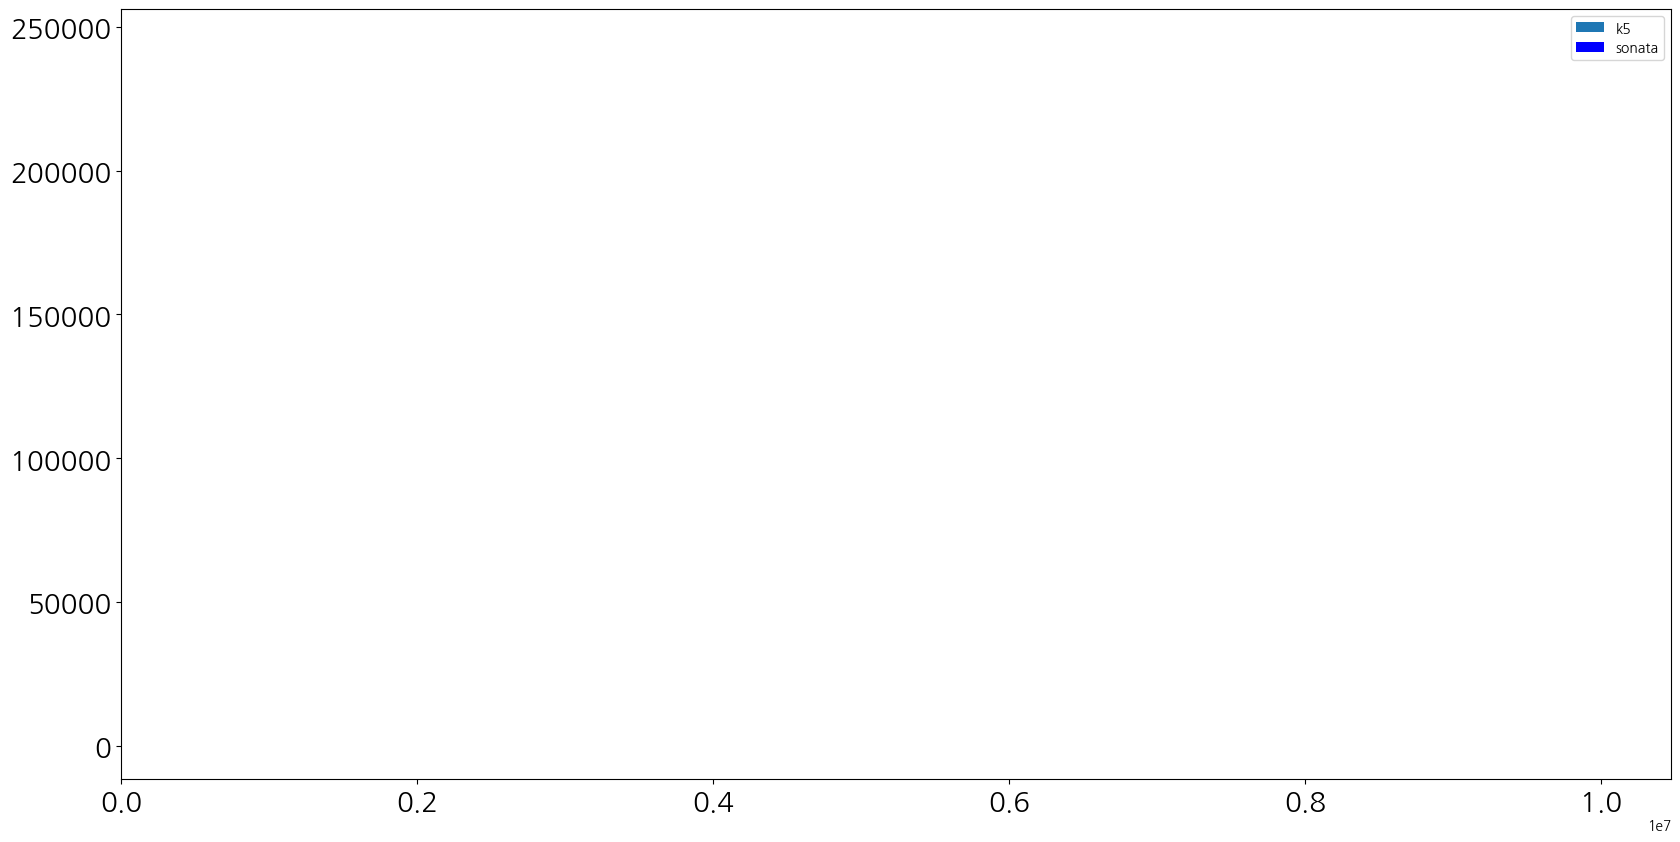

In [290]:
## df_insurance['name'] 에서 'k5' 또는 'K5' 또는 'K 5' 또는 'k 5' 만 불러와 새로운 데이터프레임 생성
df_k5 = df_insurance[df_insurance['name'].str.contains('k5') | df_insurance['name'].str.contains('K5') | df_insurance['name'].str.contains('K 5') | df_insurance['name'].str.contains('k 5')]
df_k5 = df_k5.reset_index(drop=True)

## df_insurance['name'] 에서 '쏘나타' 만 불러와 새로운 데이터프레임 생성
df_sonata = df_insurance[df_insurance['name'].str.contains('쏘나타')]
df_sonata = df_sonata.reset_index(drop=True)

## df_insurance['name'] 에서 'k5' 또는 'K5' 또는 'K 5' 또는 'k 5' 를 제외한 새로운 데이터프레임 생성
df_insurance_without_k5 = df_insurance[~df_insurance['name'].str.contains('k5') & ~df_insurance['name'].str.contains('K5') & ~df_insurance['name'].str.contains('K 5') & ~df_insurance['name'].str.contains('k 5')]

## df_k5['피해금액']의 데이터와 df_k5['distance']의 관계와 df_insurance_without_k5['피해금액']의 데이터와 df_insurance_without_k5['distance']의 관계를 비교
plt.figure(figsize=(20, 10))
plt.barh(df_k5['distance'], df_k5['피해금액'], label='k5')
plt.barh(df_sonata['distance'], df_sonata['피해금액'], color='blue', label='sonata')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend()
plt.show()

##

In [291]:
## 내차피해금액이 0인경우는 삭제
df_insurance = df_insurance[df_insurance['내차피해금액'] != 0]
df_insurance = df_insurance.reset_index(drop=True)
## 내차피해금액중에 10000000 이 넘어가면 삭제
df_insurance = df_insurance[df_insurance['내차피해금액'] < 10000000]

## 상대차피해금액 0인경우는 삭제
df_insurance = df_insurance[df_insurance['상대차피해금액'] != 0]
df_insurance = df_insurance.reset_index(drop=True)
## 상대차피해금액 10000000 이 넘어가면 삭제
df_insurance = df_insurance[df_insurance['상대차피해금액'] < 10000000]

df_insurance.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 961 entries, 0 to 960
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   brand     961 non-null    object
 1   name      961 non-null    object
 2   price     961 non-null    int64 
 3   distance  961 non-null    int64 
 4   보험처리수     961 non-null    int64 
 5   차량번호변경    961 non-null    int64 
 6   소유자변경     961 non-null    int64 
 7   전손        961 non-null    int64 
 8   침수전손      961 non-null    int64 
 9   침수분손      961 non-null    int64 
 10  도난        961 non-null    int64 
 11  내차사고건수    961 non-null    int64 
 12  내차피해금액    961 non-null    int64 
 13  상대차피해건수   961 non-null    int64 
 14  상대차피해금액   961 non-null    int64 
 15  피해금액      961 non-null    int64 
dtypes: int64(14), object(2)
memory usage: 127.6+ KB


In [292]:
## 내차피해금액이랑 상대차피해금액이랑 합쳐서 새로운 컬럼 만들기
df_insurance['피해금액'] = df_insurance['내차피해금액'] + df_insurance['상대차피해금액']
## 피해금액이 0인경우는 삭제
df_insurance = df_insurance.reset_index(drop=True)
## 피해금액중에 10000000 이 넘어가면 삭제
df_insurance = df_insurance[df_insurance['피해금액'] < 10000000]

df_insurance.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 961 entries, 0 to 960
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   brand     961 non-null    object
 1   name      961 non-null    object
 2   price     961 non-null    int64 
 3   distance  961 non-null    int64 
 4   보험처리수     961 non-null    int64 
 5   차량번호변경    961 non-null    int64 
 6   소유자변경     961 non-null    int64 
 7   전손        961 non-null    int64 
 8   침수전손      961 non-null    int64 
 9   침수분손      961 non-null    int64 
 10  도난        961 non-null    int64 
 11  내차사고건수    961 non-null    int64 
 12  내차피해금액    961 non-null    int64 
 13  상대차피해건수   961 non-null    int64 
 14  상대차피해금액   961 non-null    int64 
 15  피해금액      961 non-null    int64 
dtypes: int64(14), object(2)
memory usage: 127.6+ KB


### 보험데이터 시각화

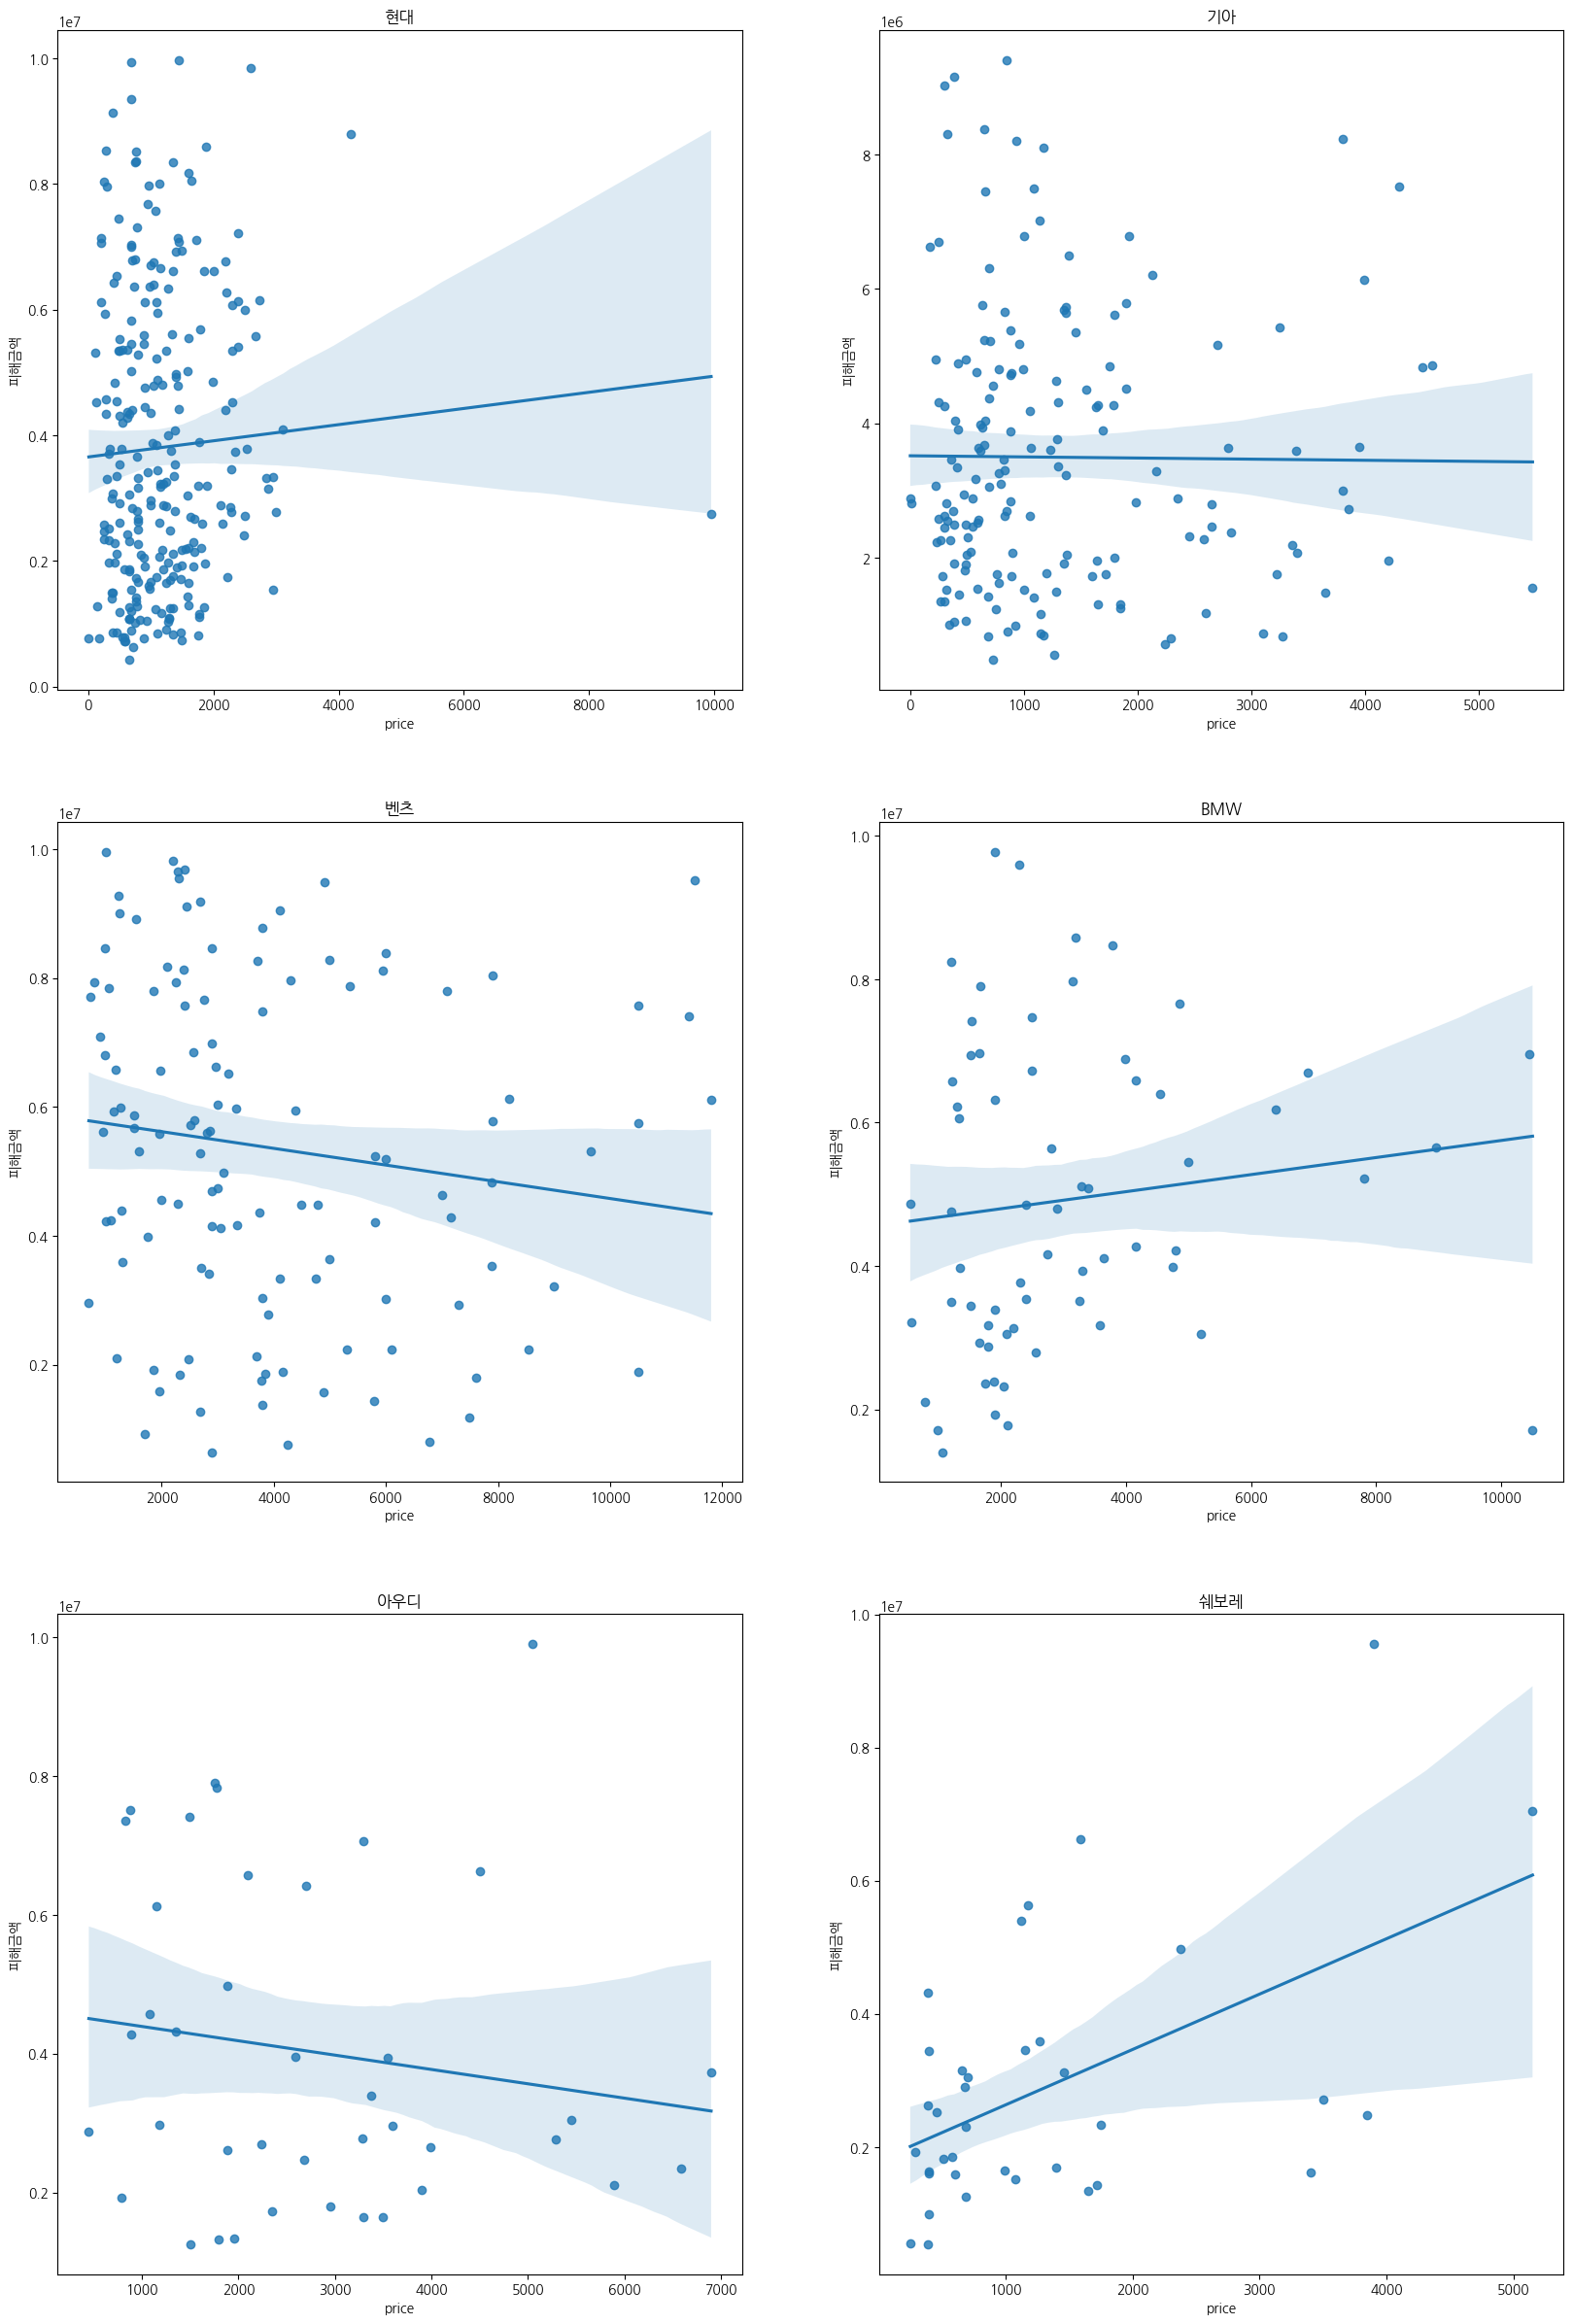

In [293]:
## 총 피해금액과 price의 상관관계를 상위10개의 브랜드로 나누어서 시각화(subplot)
brand_list = df['brand'].value_counts().index[:6]
brand_list

fig, axes = plt.subplots(3, 2, figsize=(20, 30))
for i, brand in enumerate(brand_list):
    df_brand = df_insurance[df_insurance['brand'] == brand]
    sns.regplot(x='price', y='피해금액', data=df_brand, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(brand)
    axes[i//2, i%2].set_xlabel('price')
    axes[i//2, i%2].set_ylabel('피해금액')
plt.show()


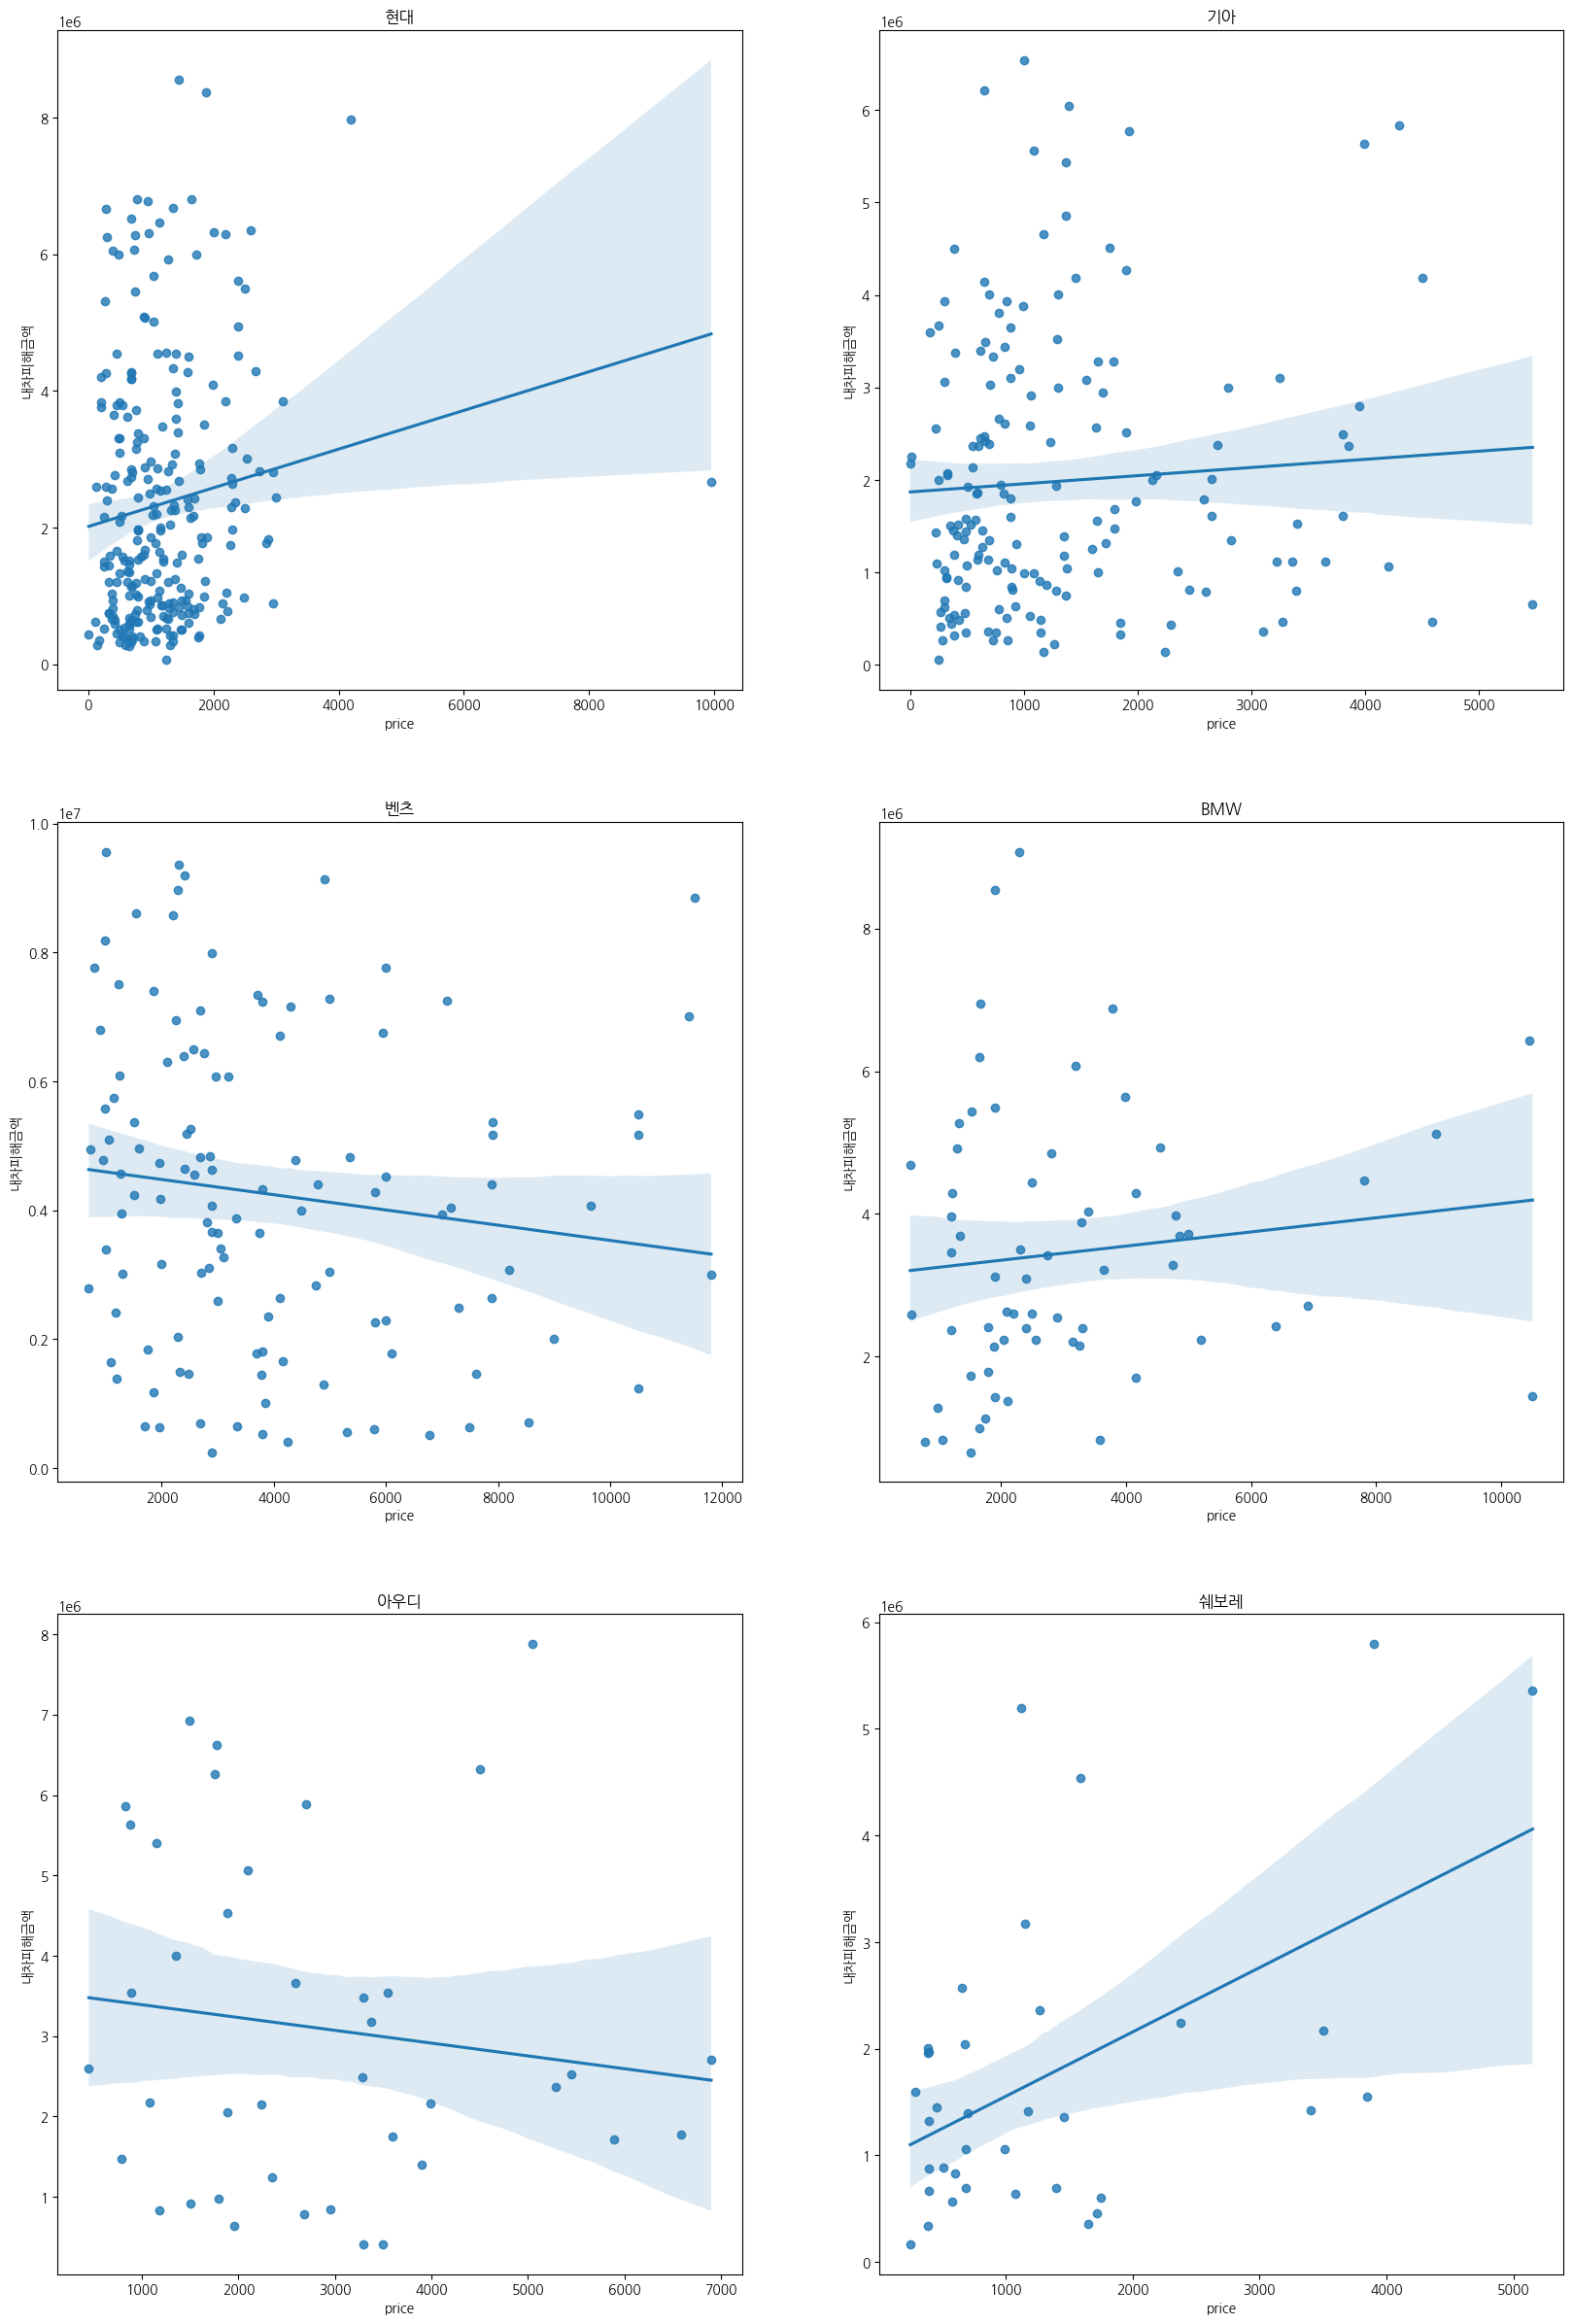

In [294]:
## 내차피해금액과 price의 상관관계를 상위10개의 브랜드로 나누어서 시각화(subplot)
brand_list = df['brand'].value_counts().index[:6]
brand_list

fig, axes = plt.subplots(3, 2, figsize=(20, 30))
for i, brand in enumerate(brand_list):
    df_brand = df_insurance[df_insurance['brand'] == brand]
    sns.regplot(x='price', y='내차피해금액', data=df_brand, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(brand)
    axes[i//2, i%2].set_xlabel('price')
    axes[i//2, i%2].set_ylabel('내차피해금액')
plt.show()


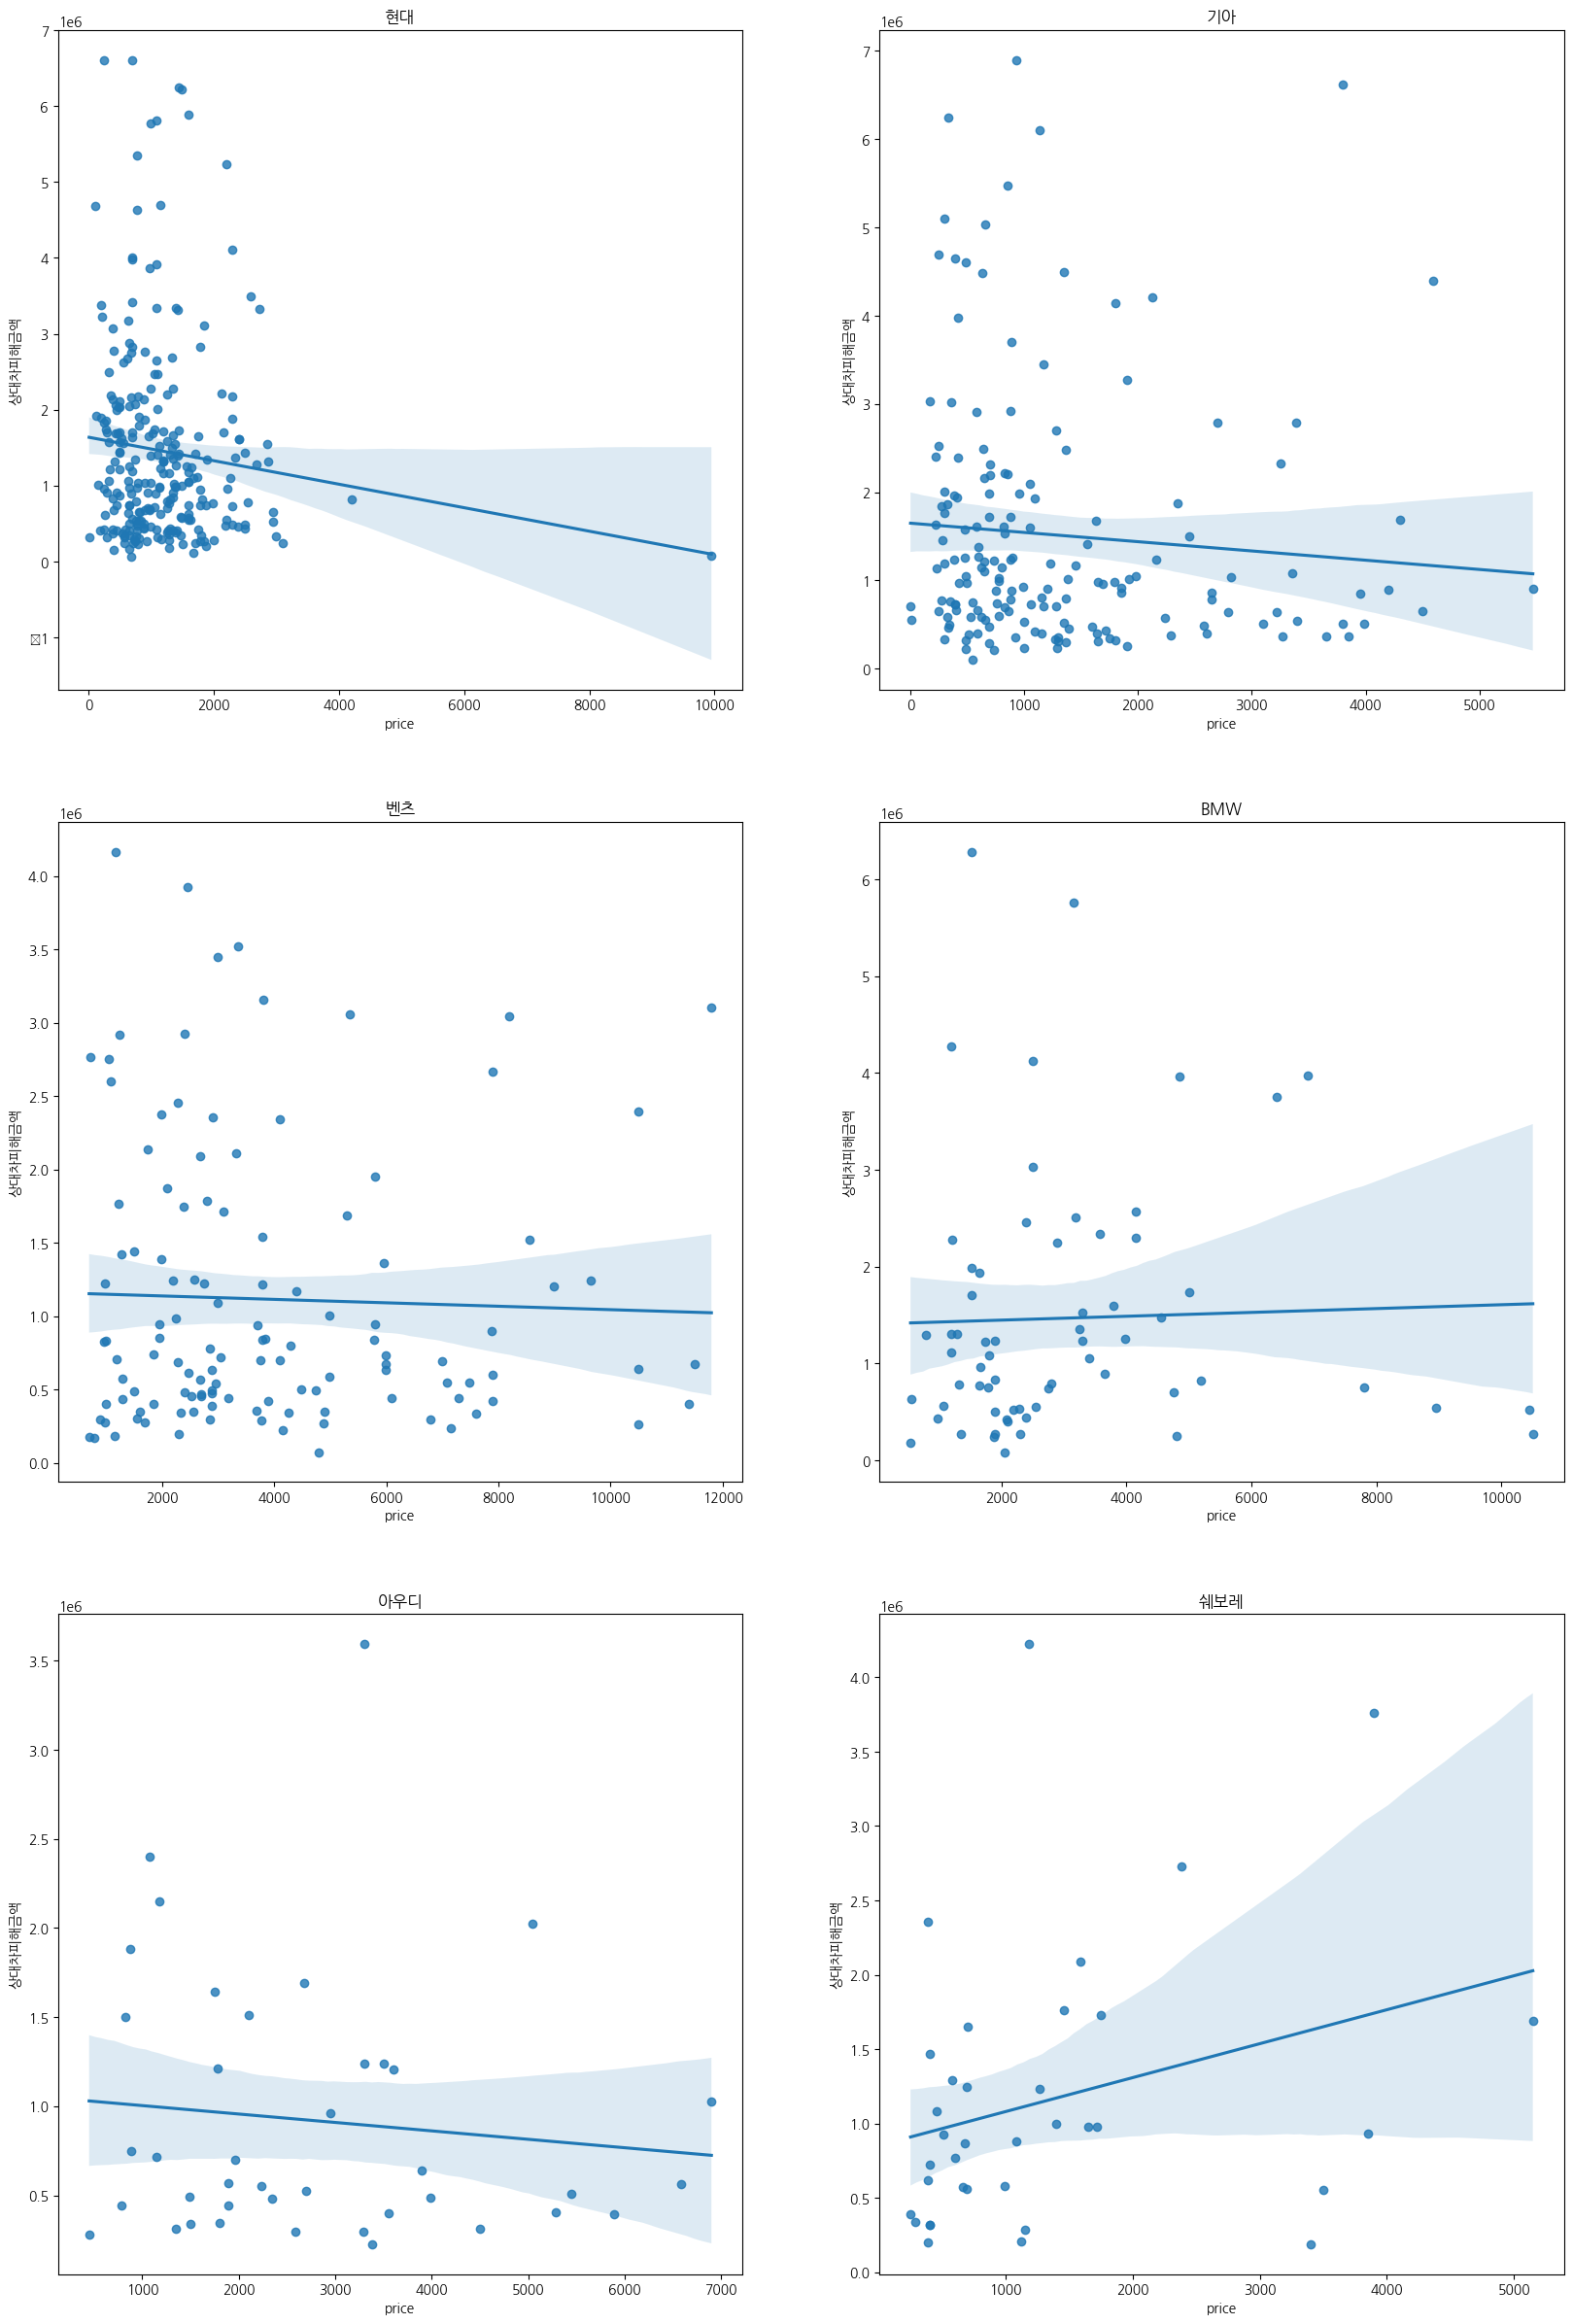

In [295]:
## 상대차피해금액과 price의 상관관계를 상위10개의 브랜드로 나누어서 시각화(subplot)
brand_list = df['brand'].value_counts().index[:6]
brand_list

fig, axes = plt.subplots(3, 2, figsize=(20, 30))
for i, brand in enumerate(brand_list):
    df_brand = df_insurance[df_insurance['brand'] == brand]
    sns.regplot(x='price', y='상대차피해금액', data=df_brand, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(brand)
    axes[i//2, i%2].set_xlabel('price')
    axes[i//2, i%2].set_ylabel('상대차피해금액')
plt.show()


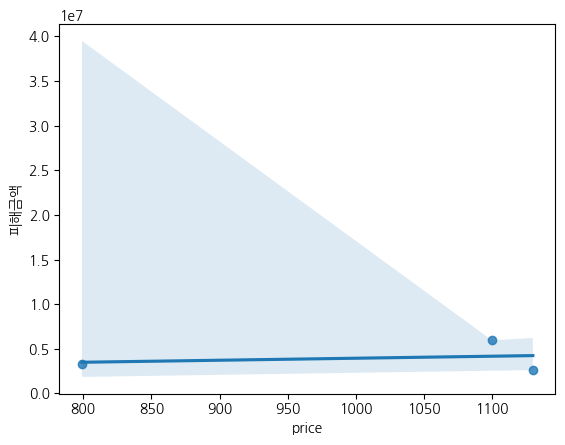

In [296]:
## 브랜드가 '현대'인 것 중에서 name컬럼 중에 '아반떼'와 '소나타'가 있는 것을 찾아서 새로운 데이터프레임에 저장
df_hyundai = df_insurance[df_insurance['brand'] == '현대']
df_hyundai = df_hyundai[df_hyundai['name'].str.contains('그랜저HG')]
df_hyundai = df_hyundai.reset_index(drop=True)
df_hyundai.tail()

## df_hyundai에서 'price'컬럼과 '피해금액'컬럼을 시각화
sns.regplot(x='price', y='피해금액', data=df_hyundai)
plt.show()


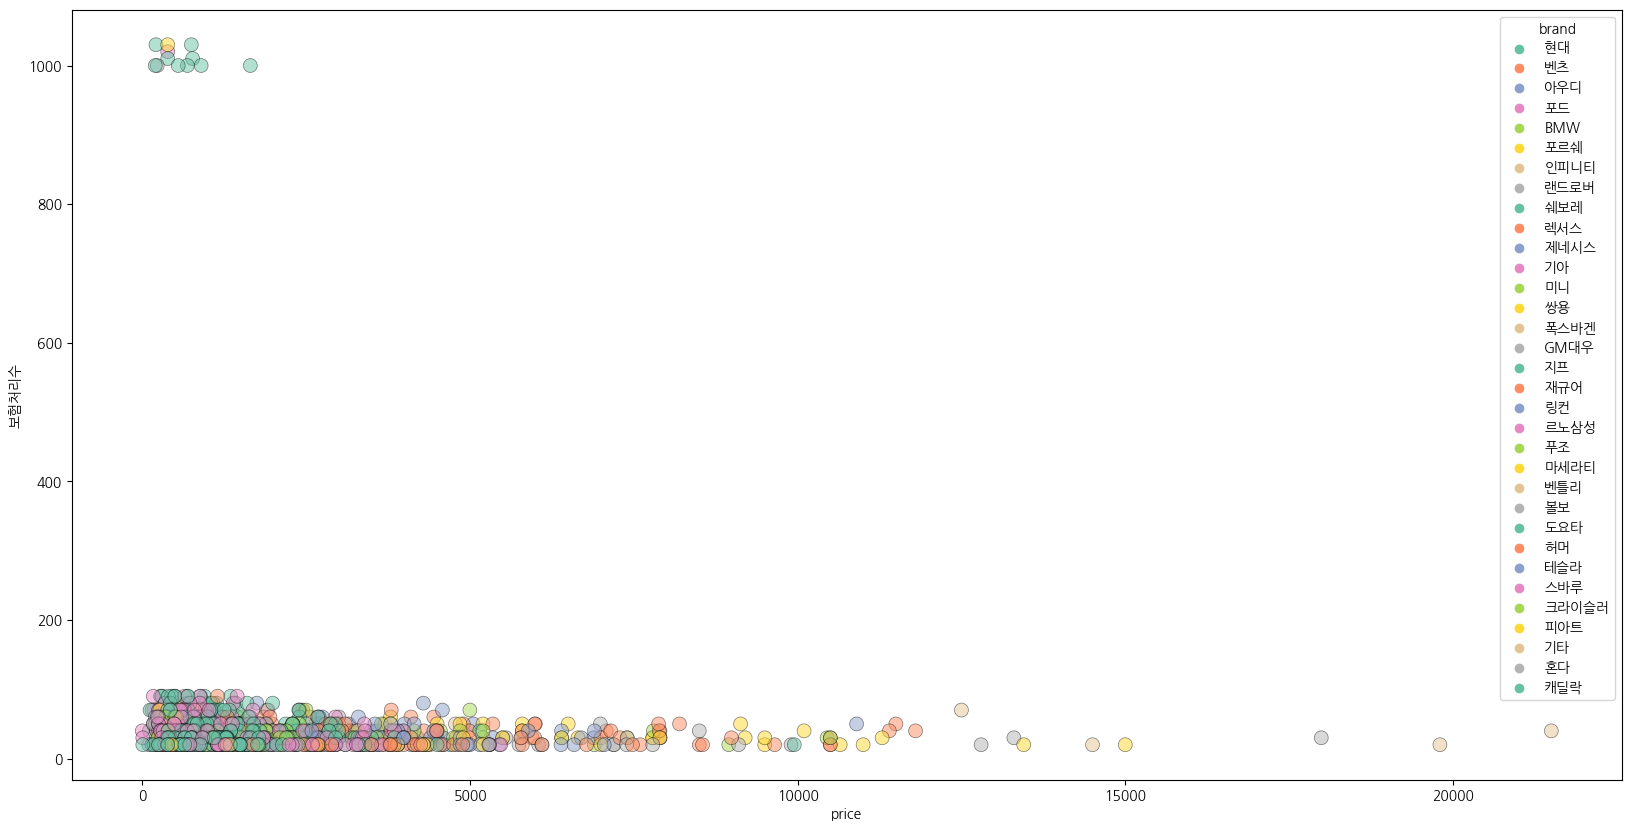

In [297]:
## 보험처리 건수가 많을수록 price이 많이 내려갈까? 한번 분포도를 통해서 브랜드 구분지어 확인해보자

## 보험처리수 컬럼의 값이 0인 데이터 삭제
df_insurance_count = df_insurance[df_insurance['보험처리수'] != 0]
df_insurance_count = df_insurance_count.reset_index(drop=True)
df_insurance_count.tail(10)

plt.figure(figsize=(20, 10))
sns.scatterplot(x='price', y='보험처리수',hue="brand" , data=df_insurance_count, palette='Set2', alpha=0.5, s=100, edgecolor='black', linewidth=0.5, marker='o')
plt.show()


## 옵션과 중고차의 관계

### 옵션데이터 가공하기

In [298]:
## 옵션데이터 가공하기


## df 에서 brand, price, distance, fuel, insurance 컬럼만 추출
df_option = df[['brand', 'price', 'distance', 'option']]
df_option.tail(10)

## df_insurance["insurance"]를 모두 문자열로 변환
df_option['option'] = df_option['option'].apply(lambda x: str(x))
df_option.tail(10)

## df_insurance["insurance"] 중에서 [nan] 또는 [[nan]] 인 데이터 삭제
df_option = df_option[df_option['option'] != '[nan]']
df_option = df_option[df_option['option'] != '[[nan]]']


df_option = df_option.reset_index(drop=True)
df_option.tail(10)

brand  price  distance  \
21541    혼다    600    100000   
21542    혼다    950    128000   
21543    혼다   1800     28000   
21544    혼다    420    182600   
21545    혼다    600    100411   
21546    혼다   1999     76900   
21547    기타  13000     23000   
21548    기타    799     14370   
21549    기타  15500       360   
21550    기타  16800      4658   

                                                  option  
21541  [['true', None, 'true', 'true', None, None, No...  
21542  [['true', None, 'true', 'true', None, None, No...  
21543  [['true', None, 'true', 'true', 'true', 'true'...  
21544  [[None, None, 'true', 'true', None, None, None...  
21545  [['true', None, 'true', 'true', 'true', None, ...  
21546  [['true', None, 'true', 'true', None, None, No...  
21547  [[None, None, None, None, None, None, None, No...  
21548  [[None, None, 'true', None, None, None, None, ...  
21549  [['true', None, 'true', None, None, None, None...  
21550  [['true', None, 'true', 'true', None, None, No...

In [299]:
## df_option['option']의 리스트를 한개 씩 컬럼에 추가
df_option = df_option.join(df_option['option'].str.split(',', expand=True).add_prefix('option_'))

## df_option['option'] 컬럼 삭제
df_option = df_option.drop(['option'], axis=1)

car_option_list=['선루프',        
  '파노라마선루프',
  '알루미늄휠',
  '전동사이드미러',
  'HID램프',
  'LED헤드램프',
  '어댑티드헤드램프',
  'LED리어램프',
  '데이라이트',
  '하이빔어시스트',
  '압축도어',
  '자동슬라이딩도어',
  '전동사이드스탭',
  '루프랙',
  '가죽시트',
  '전동시트(운전석)',
  '전동시트(동승석)',
  '열선시트(앞좌석)',
  '열선시트(뒷좌석)',
  '통풍시트',
  '메모리시트',
  '폴딩시트',
  '마사지시트',
  '워크인시트',
  '요추받침',
  '하이패스룸미러',
  'ECM룸미러',
  '뒷좌석에어벤트',
  '패들쉬프트',
  '전동햇빛가리개',
  '엠비언트라이트',
  '동승석에어백',
  '측면에어백',
  '커튼에어백',
  '무릎에어백',
  '승객감지에어백',
  '브레이크잠김방지(ABS)',
  '차체자세제어장치(ESC)',
  '후방센서',
  '전방센서',
  '후방카메라',
  '전방카메라',
  '어라운드뷰',
  '타이어공기압감지(TPMS)',
  '차선이탈경보(LDWS)',
  '자동긴급제동',
  '전자제어서스펜션(ECS)',
  '후측방경보',
  '미끄럼방지(TCS)',
  '스마트키',
  '열선핸들',
  '리모컨핸들',
  '자동에어컨',
  '좌우독립에어컨',
  '오토라이트',
  '크루즈컨트롤',
  '스마트크루즈컨트롤',
  '스탑앤고',
  '전동트렁크',
  '스마트트렁크',
  '전자주차브레이크(EPB)',
  '경사로밀림방지',
  '헤드업디스플레이(HUD)',
  '무선충전',
  '자동주차',
  '냉장고',
  '네비게이션(순정)',
  '네비게이션(비순정)',
  'USB',
  'AUX',
  '블루투스',
  'MP3',
  'DMB',
  'CD플레이어',
  'AV시스템',
  '뒷좌석TV',
  '텔레매틱스',
  '스마트폰미러링']


## df의 컬럼 [option_1]부터 [option_81]까지 car_option_list로 교체
df_option.rename(columns = dict(zip(df_option.columns[3:85], car_option_list)), inplace=True)

## df_option을 str로 변환
df_option = df_option.astype(str)

In [300]:
df_option

brand  price distance       선루프  파노라마선루프    알루미늄휠  전동사이드미러    HID램프  \
0        현대   3990   150129    [[None     None     None     None     None   
1        현대   5200     4400  [['true'     None   'true'   'true'     None   
2        현대   3290    46211    [[None   'true'   'true'   'true'     None   
3        현대   1099   106982    [[None     None   'true'   'true'     None   
4        현대   1099   168000  [['true'   'true'   'true'   'true'   'true'   
...     ...    ...      ...       ...      ...      ...      ...      ...   
21546    혼다   1999    76900  [['true'     None   'true'   'true'     None   
21547    기타  13000    23000    [[None     None     None     None     None   
21548    기타    799    14370    [[None     None   'true'     None     None   
21549    기타  15500      360  [['true'     None   'true'     None     None   
21550    기타  16800     4658  [['true'     None   'true'   'true'     None   

       LED헤드램프 어댑티드헤드램프  ...      USB      AUX     블루투스      MP3      DMB  \
0         None     None  ...     None     None     None     None     None   
1       'true'     None  ...   'true'     None   'true'   'true'     None   
2       'true'   'true'  ...   'true'   'true'   'true'     None     None   
3         None     None  ...   'true'   'true'   'true'   'true'     None   
4         None   'true'  ...   'true'   'true'   'true'   'true'   'true'   
...        ...      ...  ...      ...      ...      ...      ...      ...   
21546     None     None  ...     None   'true'     None   'true'   'true'   
21547     None     None  ...   'true'     None   'true'     None     None   
21548     None     None  ...     None     None   'true'   'true'     None   
21549     None     None  ...   'true'   'true'   'true'     None     None   
21550     None     None  ...   'true'   'true'   'true'     None     None   

        CD플레이어    AV시스템    뒷좌석TV    텔레매틱스    스마트폰미러링  
0       'true'     None     None     None     None]]  
1         None     None     None     None     None]]  
2         None   'true'     None   'true'   'true']]  
3       'true'     None     None     None     None]]  
4         None   'true'     None     None     None]]  
...        ...      ...      ...      ...        ...  
21546   'true'     None     None     None     None]]  
21547     None     None   'true'     None     None]]  
21548     None     None     None     None     None]]  
21549     None     None     None     None     None]]  
21550     None     None   'true'     None   'true']]  

[21551 rows x 81 columns]

### 옵션들로 시각화 하기

In [301]:
df_option.iloc[:,20:36]

열선시트(앞좌석) 열선시트(뒷좌석)     통풍시트    메모리시트   폴딩시트  마사지시트    워크인시트     요추받침  \
0          None      None     None     None   None   None     None     None   
1        'true'    'true'   'true'   'true'   None   None     None     None   
2        'true'    'true'   'true'   'true'   None   None   'true'   'true'   
3        'true'      None     None     None   None   None     None     None   
4        'true'    'true'   'true'   'true'   None   None     None   'true'   
...         ...       ...      ...      ...    ...    ...      ...      ...   
21546    'true'      None     None     None   None   None     None     None   
21547      None      None     None     None   None   None     None     None   
21548      None      None     None     None   None   None     None     None   
21549      None      None     None     None   None   None     None     None   
21550      None      None     None     None   None   None     None     None   

       하이패스룸미러   ECM룸미러  뒷좌석에어벤트    패들쉬프트  전동햇빛가리개   엠비언트라이트    동승석에어백  \
0         None     None     None     None     None     None]     [None   
1         None   'true'   'true'     None     None   'true']   ['true'   
2       'true'   'true'   'true'     None   'true'     None]   ['true'   
3         None     None     None     None     None     None]     [None   
4       'true'   'true'     None   'true'   'true'     None]   ['true'   
...        ...      ...      ...      ...      ...       ...       ...   
21546     None     None   'true'     None     None     None]   ['true'   
21547     None     None     None     None     None     None]     [None   
21548     None     None     None     None     None     None]     [None   
21549     None     None     None     None     None     None]   ['true'   
21550   'true'     None     None     None     None   'true']   ['true'   

         측면에어백  
0         None  
1       'true'  
2       'true'  
3         None  
4       'true'  
...        ...  
21546   'true'  
21547     None  
21548     None  
21549   'true'  
21550     None  

[21551 rows x 16 columns]

### 연료별 데이터 가공

In [302]:
## 연료별로 df 정렬
df = df.sort_values(by=['fuel'], axis=0, ascending=True)
df


brand                       name            year  distance fuel  price  \
12684  GM대우              라보 이동판매차 -     07년 02월 (06년형)     33000  LPG   1100   
920      현대        그랜저IG 3.0 LPi 모던     18년 07월 (19년형)     82819  LPG   2050   
10680    기아        K5 2.0 LPi 프레스티지     11년 11월 (12년형)     69734  LPG    580   
3534     현대  더 럭셔리 그랜져 Q270 LPi 모범형           11년 01월식    185510  LPG    890   
9281     기아    뉴 카렌스 2.0 LPi GX 고급형     06년 07월 (07년형)    279166  LPG    190   
...     ...                        ...             ...       ...  ...    ...   
24037   테슬라            모델 3 롱 레인지 -           22년 03월식       150   전기   7300   
24036   테슬라            모델 X 롱 레인지 -           20년 09월식     36000   전기  13700   
24035   테슬라            모델 3 롱 레인지 -           22년 03월식      1830   전기   6899   
24033   테슬라            모델 3 롱 레인지 -           21년 09월식     10768   전기   6500   
14172    벤츠            EQA 250 AMG팩           22년 12월식        29   전기   6090   

                   avg                cc          color  \
12684       [50,  170]     796 cc (38마력)   빨간색 (베이지 투톤)   
920      [1200,  2550]  2,999 cc (235마력)             흰색   
10680       [80,  730]  1,999 cc (144마력)            검정색   
3534       [170,  610]  2,656 cc (165마력)            검정색   
9281       [120,  240]  1,998 cc (136마력)             은색   
...                ...               ...            ...   
24037    [4500,  7000]      0 cc (476마력)  진회색 (미드나잇 실버)   
24036  [10500,  12000]           0 cc ()             흰색   
24035    [4500,  7000]    236 cc (476마력)            검정색   
24033    [4100,  6400]    236 cc (476마력)             흰색   
14172    [4900,  6000]    190 cc (190마력)   회색 (마운틴 그레이)   

                                                  option  \
12684                                              [nan]   
920    [[None, true, true, true, None, None, None, tr...   
10680                                              [nan]   
3534   [[None, None, true, true, None, None, None, tr...   
9281   [[None, None, None, None, None, None, None, No...   
...                                                  ...   
24037  [[None, None, true, None, None, true, true, tr...   
24036                                              [nan]   
24035  [[None, None, None, true, None, true, true, tr...   
24033  [[None, None, true, true, None, true, None, tr...   
14172  [[None, true, true, true, None, true, None, tr...   

                                             insurance  
12684                                            [nan]  
920                                              [nan]  
10680                                            [nan]  
3534                                             [nan]  
9281                                             [nan]  
...                                                ...  
24037                                            [nan]  
24036  [2, 0, 0, 0, 0, 0, 0, 2, (4,424,098원), 0, (0원)]  
24035          [0, 0, 0, 0, 0, 0, 0, 0, (0원), 0, (0원)]  
24033                                            [nan]  
14172          [0, 0, 0, 0, 0, 0, 0, 0, (0원), 0, (0원)]  

[25370 rows x 11 columns]

### 현대 그렌져 차량 분석

#### 연로별 연 평균 주행거리

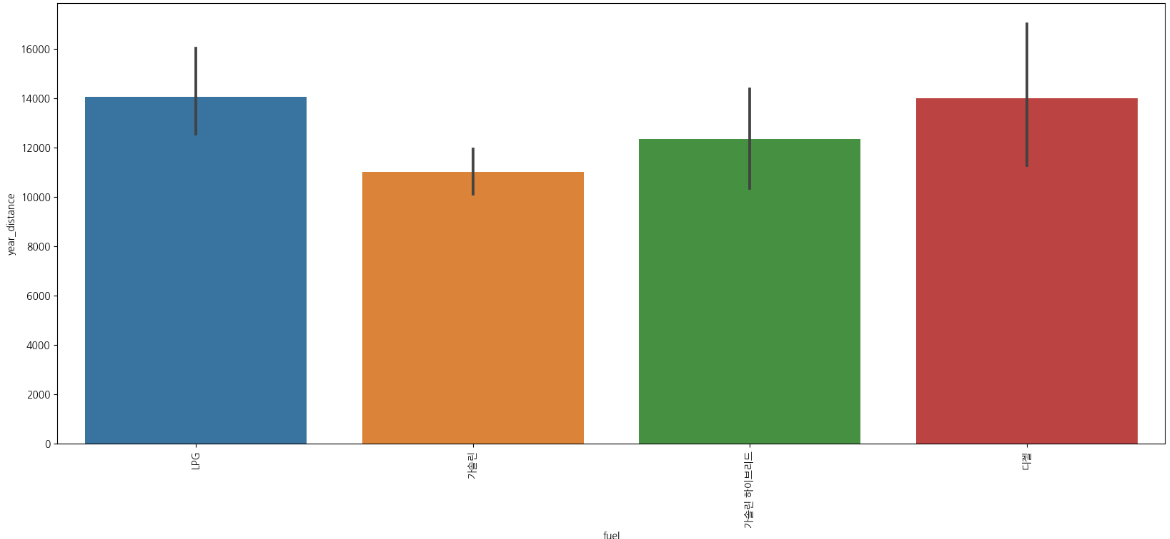

### 그렌저 가격/연식

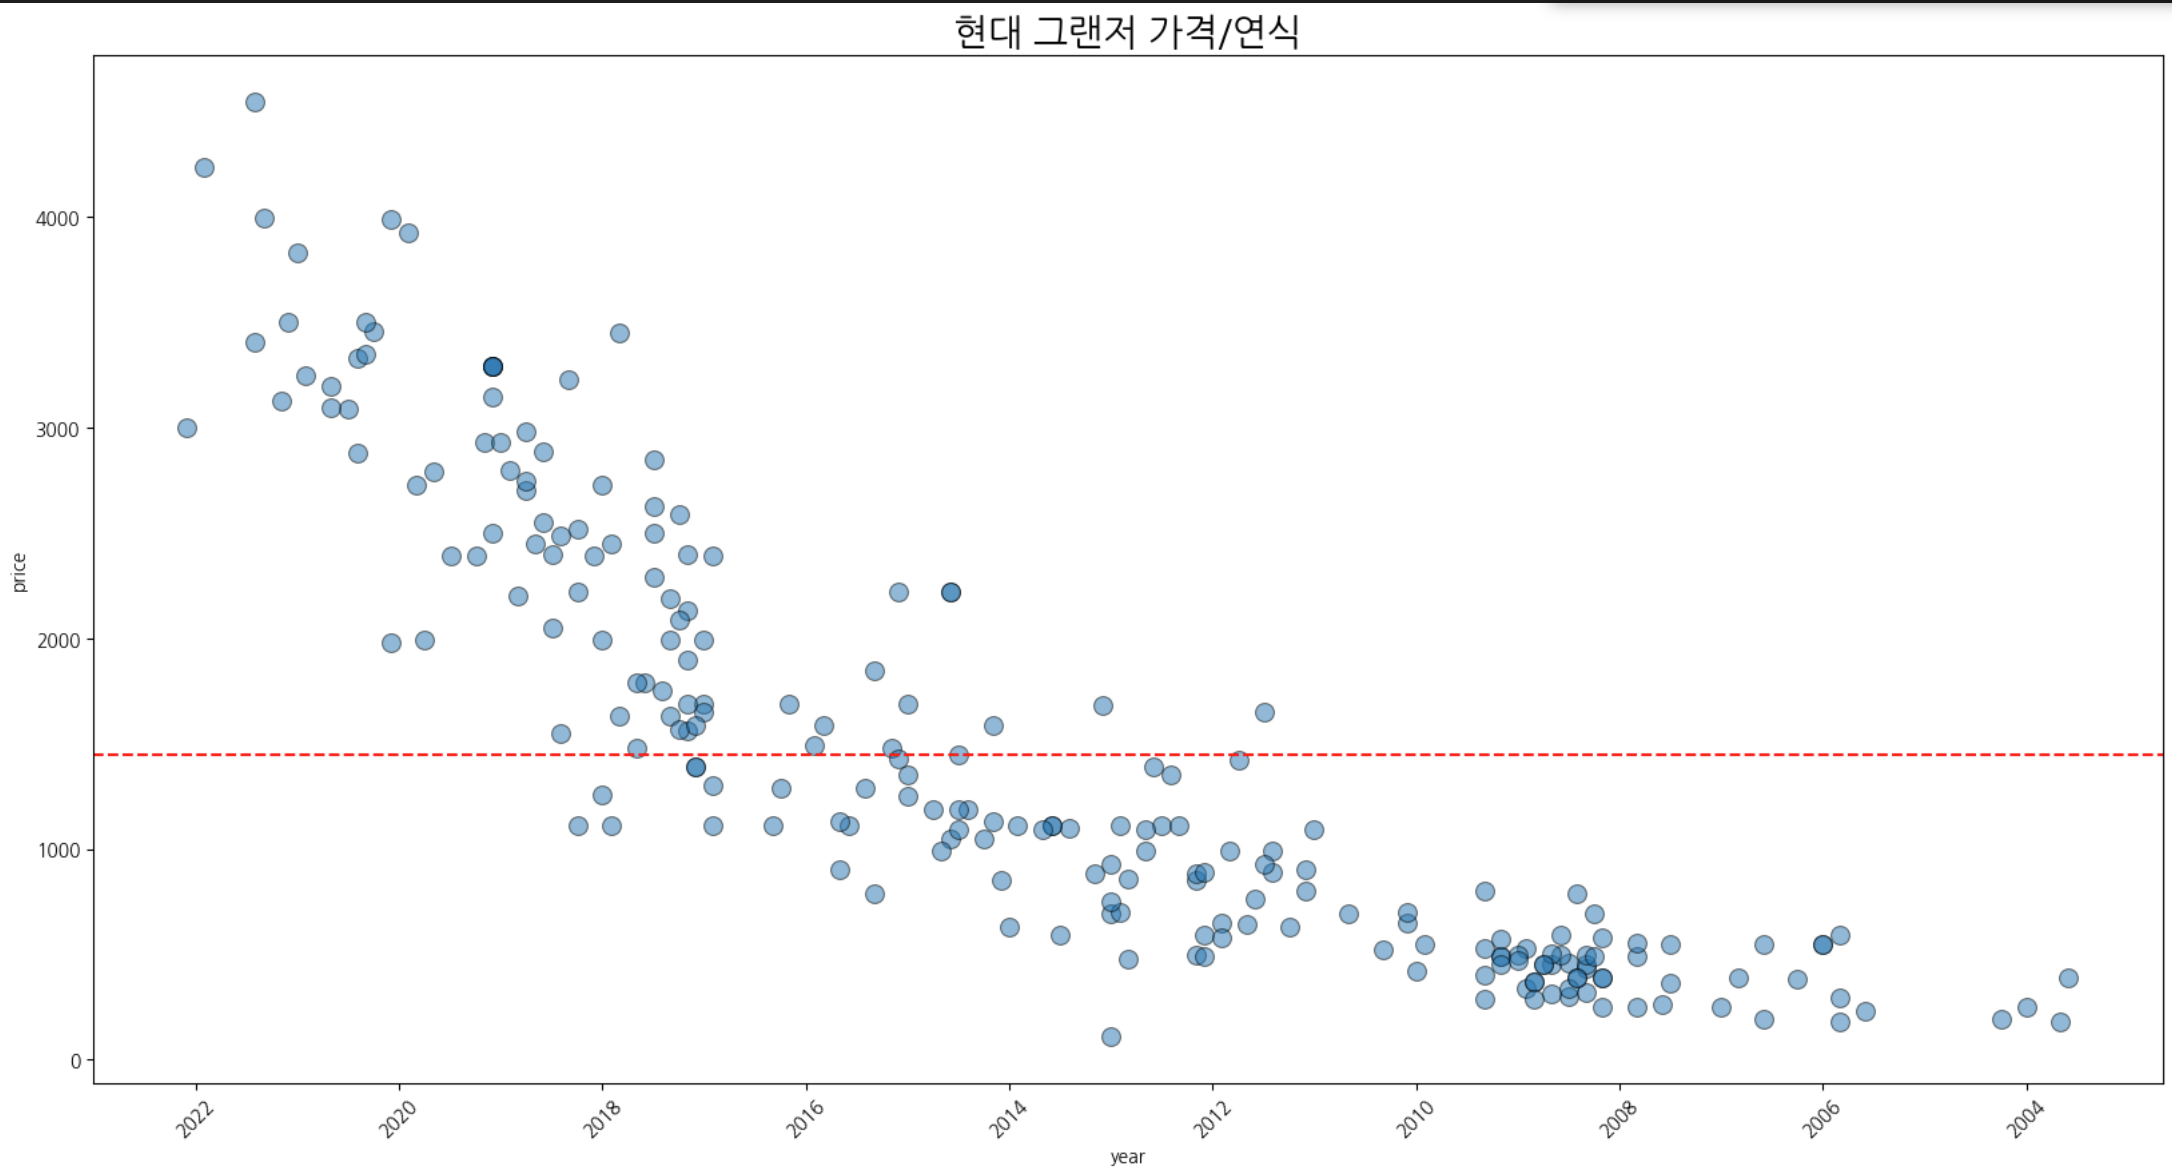

### 그렌져 가격/주행거리

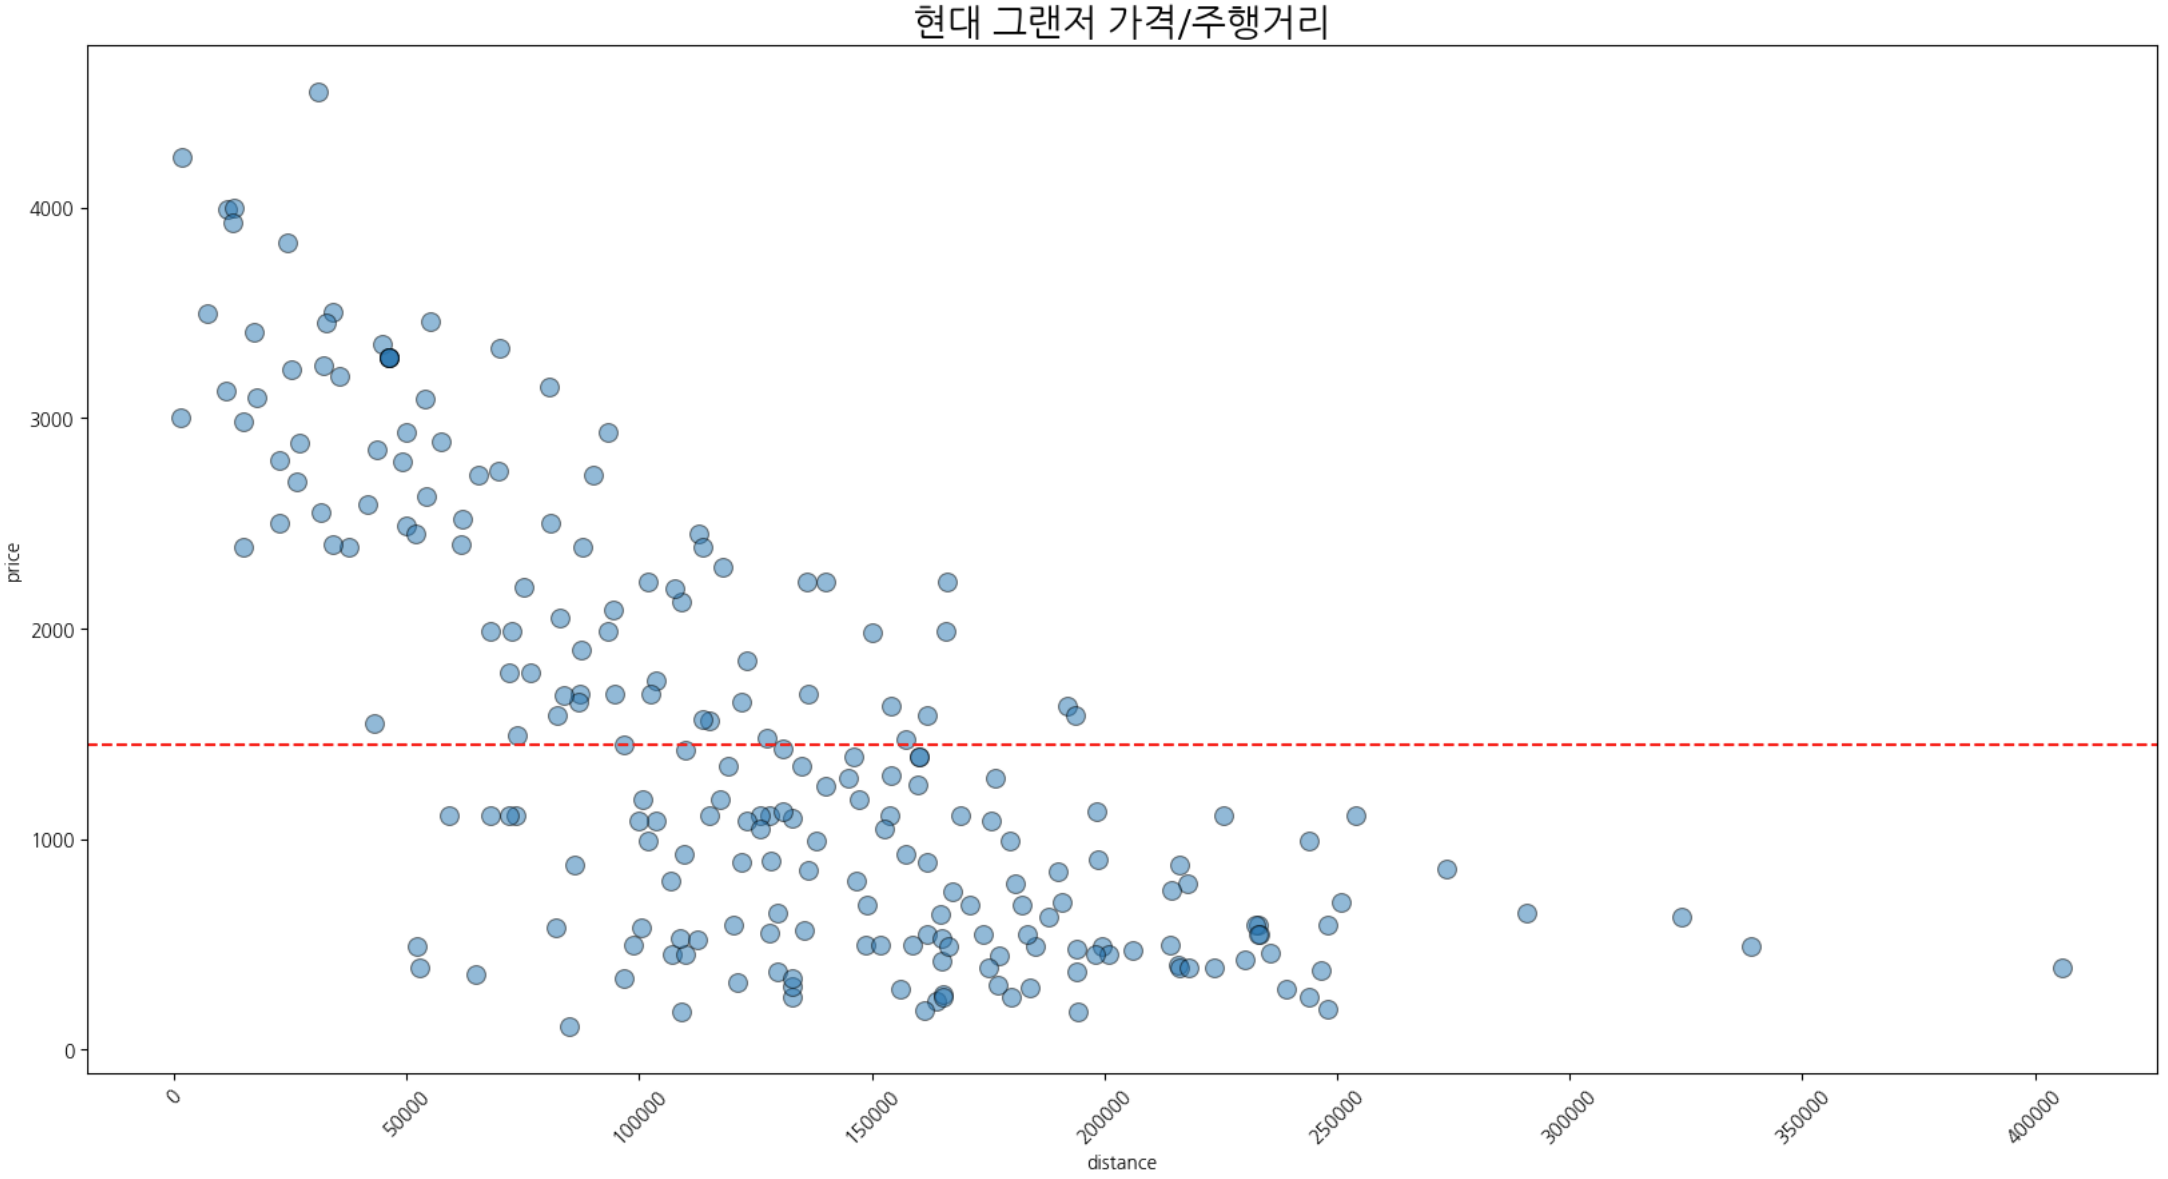

### 결론

## 감사합니다

In [303]:
# year 스트링으로 변환
df['year'] = df['year'].apply(lambda x: re.findall('\d+', x))
car_year=[]

# 출고일 ~ 현재년도 까지의 차량 연식
for i in range(len(df)):
   if int(df['year'][i][0])<30:
      car_year.append((24-int(df['year'][i][0])))

   else:
      car_year.append((124-int(df['year'][i][0])))


# df에 car_year 추가
df['car_year'] = car_year

## distanc를 car_year 나누기
df['year_distance'] = round(df['distance'] / df['car_year'])

# year_distnace로 정렬
df = df.sort_values(by=['year_distance'], axis=0)

## car_year 0.0값 삭제
df = df[df['year_distance'] != 0.0]
df = df.reset_index(drop=True)

##brand 에서 현대차 name에 그랜저가 포함된 데이터만 추출
hyundai_df = df[df['brand'].str.contains('현대')]
hyundai_df = hyundai_df[hyundai_df['name'].str.contains('그랜저')]
hyundai_df = hyundai_df.reset_index(drop=True)
hyundai_df


brand                               name          year  distance fuel  \
0      현대                 더 뉴 그랜저 2.5 르블랑         [22, 02]      1500  가솔린   
1      현대          더 뉴 그랜저 3.0 LPi 익스클루시브     [21, 12, 22]      1740  LPG   
2      현대               더 뉴 그랜저 3.3 캘리그래피     [19, 12, 20]     12600  가솔린   
3      현대               더 뉴 그랜저 3.3 캘리그래피         [20, 02]     11347  가솔린   
4      현대                  그랜저IG 2.4 프리미엄         [19, 07]     14983  가솔린   
..    ...                                ...           ...       ...  ...   
220    현대  그랜저 뉴 럭셔리 2.7 LPi Q270 모범형 팩 I     [08, 11, 09]    194000  LPG   
221    현대                그랜저TG Q270 LPi -     [05, 11, 06]    194207  LPG   
222    현대          그랜저 뉴 럭셔리 2.7 Q270 럭셔리     [08, 10, 09]    198000  가솔린   
223    현대            더 럭셔리 그랜저 Q270 LPi -     [09, 12, 10]    161958  LPG   
224    현대               그랜저HG 3.0 LPi 개인형         [14, 01]    324000  LPG   

     price            avg                cc color  \
0     2999  [2050,  3950]  2,497 cc (198마력)    흰색   
1     4240  [2050,  3950]  2,999 cc (235마력)   검정색   
2     3930  [1700,  3500]  3,342 cc (290마력)   진주색   
3     3990  [1700,  3500]  3,342 cc (290마력)    흰색   
4     2390  [1200,  2550]  2,359 cc (190마력)    흰색   
..     ...            ...               ...   ...   
220    369    [150,  390]  2,656 cc (165마력)   검정색   
221    180     [70,  270]  2,656 cc (165마력)   검정색   
222    450    [150,  390]  2,656 cc (195마력)    흰색   
223    550    [150,  580]  2,656 cc (165마력)   진주색   
224    630   [300,  1150]  2,999 cc (235마력)    흰색   

                                                option  \
0    [[None, None, true, true, None, true, None, tr...   
1    [[true, true, true, true, true, true, true, tr...   
2                                                [nan]   
3    [[None, true, true, true, None, true, true, tr...   
4                                                [nan]   
..                                                 ...   
220  [[None, None, true, true, None, None, None, No...   
221  [[None, None, true, true, None, None, None, No...   
222  [[true, None, true, true, None, None, None, No...   
223  [[None, None, true, true, None, None, None, No...   
224  [[None, None, true, true, None, None, None, No...   

                                   insurance  car_year  year_distance  
0    [1, 0, 1, 1, 0, 0, 0, 1, (0원), 0, (0원)]        13          115.0  
1    [0, 0, 1, 0, 0, 0, 0, 0, (0원), 0, (0원)]         9          193.0  
2    [0, 0, 0, 0, 0, 0, 0, 0, (0원), 0, (0원)]        17          741.0  
3                                      [nan]        13          873.0  
4                                      [nan]        15          999.0  
..                                       ...       ...            ...  
220                                    [nan]         3        64667.0  
221                                    [nan]         3        64736.0  
222                                    [nan]         3        66000.0  
223                                    [nan]         2        80979.0  
224                                    [nan]         4        81000.0  

[225 rows x 13 columns]

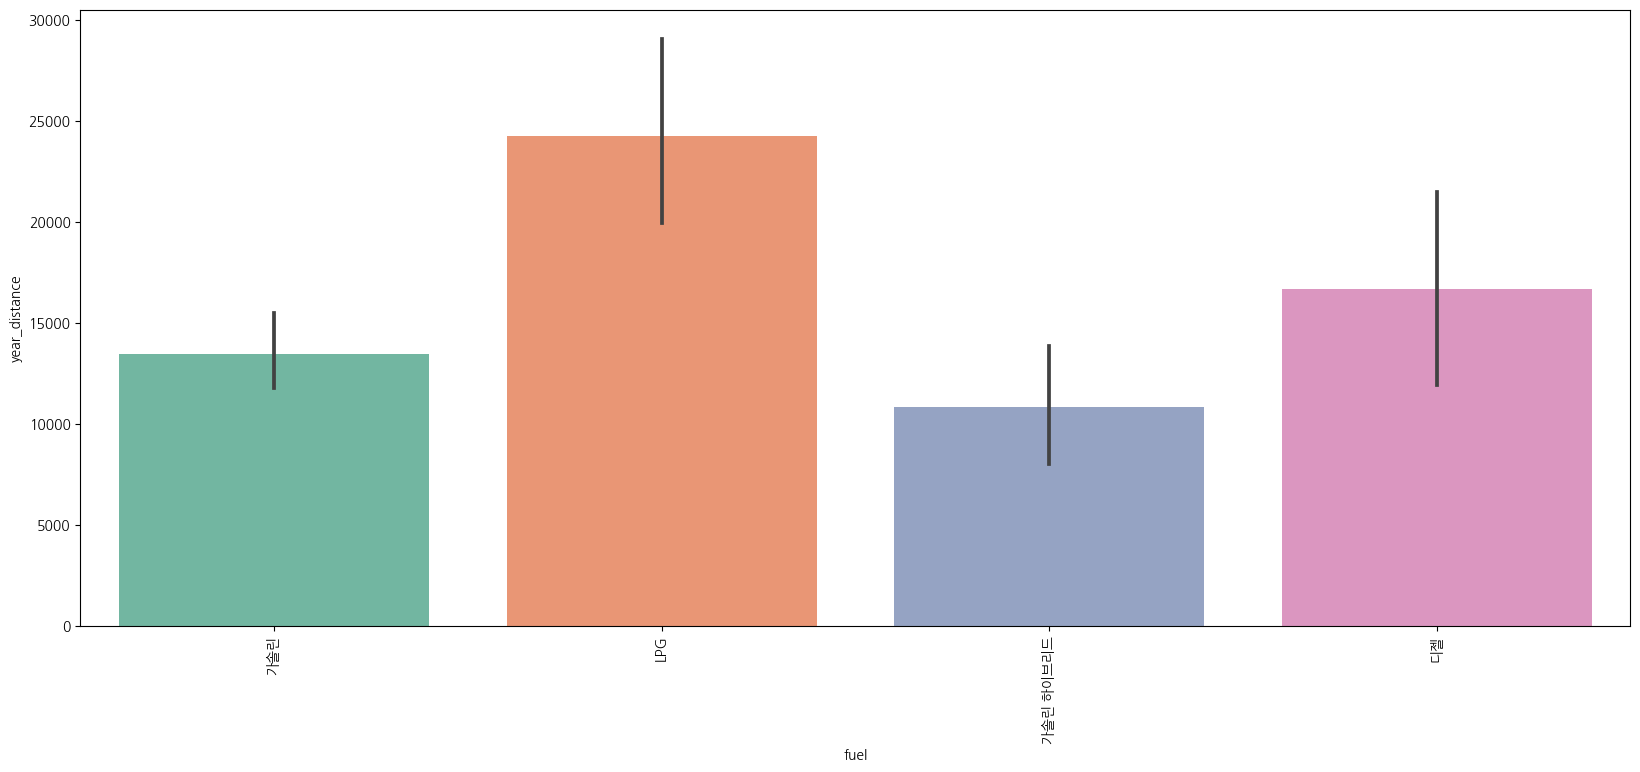

In [309]:
hyundai_df = hyundai_df.sort_values(by=['year_distance'], ascending=True)
## 현대차 그랜저 fuel 와 year_distance 시각화
plt.figure(figsize=(20, 8))
sns.barplot(x='fuel', y='year_distance', data=hyundai_df, palette='Set2')
plt.xticks(rotation=90)
plt.show()

In [10]:
# car_list 로 데이터 프레임 만들기
df = pd.DataFrame(car_list)

## 데이터 프레임 컬럼 이름 변경 (브랜드, 이름, 연식, 주행거리, 연료, 가격, 평균기, 배기량, 색상, 옵션, 보험)
df.columns = ['brand', 'name', 'year', 'distance', 'fuel', 'price', 'avg', 'cc', 'color', 'option', 'insurance']
## 컬럼들(brand name year distance fuel price avg cc color option insurance)의 리스트를 문자열로 변환하기
df['brand'] = df['brand'].apply(lambda x: ' '.join(x))
df['name'] = df['name'].apply(lambda x: ' '.join(x))
df['year'] = df['year'].apply(lambda x: ' '.join(x))
df['distance'] = df['distance'].apply(lambda x: ' '.join(x))
df['fuel'] = df['fuel'].apply(lambda x: ' '.join(x))
df['price'] = df['price'].apply(lambda x: ' '.join(x))
#df['avg'] = df['avg'].apply(lambda x: ' '.join(x))
df['cc'] = df['cc'].apply(lambda x: ' '.join(x))
df['color'] = df['color'].apply(lambda x: ' '.join(x))
#df['option'] = df['option'].apply(lambda x: ' '.join(x))
#df['insurance'] = df['insurance'].apply(lambda x: ' '.join(x))

## distance의 mi가 포함되어있으면 1mi를 1.609344km로 변환하고 km가 포함되어있으면 km를 제거
for i in range(len(df)):
    if 'mi' in df['distance'][i]:
        df['distance'][i] = df['distance'][i].replace('mi', '')
        df['distance'][i] = df['distance'][i].replace(' ', '')
        df['distance'][i] = df['distance'][i].replace(',', '')
        df['distance'][i] = int(float(df['distance'][i]) * 1.609344)
    else:
        df['distance'][i] = df['distance'][i].replace('km', '')
        df['distance'][i] = df['distance'][i].replace(' ', '')
        df['distance'][i] = df['distance'][i].replace(',', '')
        df['distance'][i] = int(df['distance'][i])
        

## distance를 int로 변환
df['distance'] = df['distance'].apply(lambda x: int(x))

## price에서 [판매완료], [계약] 이라고 적혀있는 데이터는 삭제
df = df[df['price'] != '[판매완료]']
df = df[df['price'] != '[계약]']
df = df[df['price'] != '[가격상담]']
df = df[df['price'] != '[만료]']
df = df[df['price'] != '[보류]']
## 인덱스 재정렬
df = df.reset_index(drop=True)

## price를 int로 변환
df['price'] = df['price'].apply(lambda x: int(x.replace(',', '')))


## price 중에 9999, 0, 99999 인 데이터 삭제
## price 중에 30000이 넘으면 삭제
df = df[df['price'] < 30000]
df = df[df['price'] != 9999]
df = df[df['price'] != 0]
df = df[df['price'] != 99999]
df = df[df['price'] != 999999]
df = df[df['price'] != 9999999]
df = df[df['price'] != 99999999]
df = df[df['price'] != 999999999]
df = df[df['price'] != 9999999999]

## 인덱스 재정렬
df = df.reset_index(drop=True)
df.tail(1)


brand               name      year  distance fuel  price           avg  \
25377    기타  수입차 희소차량 올드카 -     86년 00월식    470036   디젤   2500  [[nan, nan]]   

                cc color option insurance  
25377  6,000 cc ()   하늘색  [nan]     [nan]

In [11]:

## 브랜드가 '현대'인 것 중에서 name컬럼 중에 '아반떼'와 '소나타'가 있는 것을 찾아서 새로운 데이터프레임에 저장
df_hyundai = df[df['brand'] == '현대']
df_hyundai = df_hyundai[df_hyundai['name'].str.contains('그랜저')]
df_hyundai = df_hyundai.reset_index(drop=True)
df_hyundai.tail()
        


## df['year']에서 괄호가 있다면 괄호 로 스플릿하여 괄호 뒤부터는 삭제
for i in range(len(df)):
    if '(' in df['year'][i]:
        df['year'][i] = df['year'][i].split('(')[0]
        df['year'][i] = df['year'][i].replace(' ', '')
        
## df['year']에서 식이라고 적혀있으면 '식'만 삭제
for i in range(len(df)):
    if '식' in df['year'][i]:
        df['year'][i] = df['year'][i].replace('식', '')
        df['year'][i] = df['year'][i].replace(' ', '')
        
## df['year']를 datatime으로 변환할수 있게끔 (~년~월)을 (~~)로 변경
for i in range(len(df)):
    if '년' in df['year'][i]:
        df['year'][i] = df['year'][i].replace('년', '-')
        df['year'][i] = df['year'][i].replace('월', '')
        df['year'][i] = df['year'][i].replace(' ', '') 
## df에서 year가 뒷부분이 00이면 01로 변경
for i in range(len(df)):
    if df['year'][i][-2:] == '00':
        df['year'][i] = df['year'][i][:-2] + '01'
        



## df['year']를 str로 변환후 datetime으로 변환
from datetime import datetime
df['year'] = df['year'].apply(lambda x: str(x))
df['year'] = df['year'].apply(lambda x: datetime.strptime(x, '%y-%m'))

## df_hyundai['year']에서 2000년 이전 데이터 삭제
df_hyundai = df_hyundai[df_hyundai['year'] > '2000-01-01']
df_hyundai = df_hyundai.reset_index(drop=True)

df_hyundai.tail(2)

brand                     name      year  distance fuel  price  \
19    현대  더 뉴 그랜저 3.0 LPi 프리미엄     20년 06월식     27000  LPG   2880   
20    현대     더 뉴 그랜저 2.5 캘리그래피     21년 02월식      7237  가솔린   3499   

              avg                cc color  \
19  [1700,  3500]  2,999 cc (235마력)   검정색   
20  [1850,  3750]  2,497 cc (198마력)   진청색   

                                               option  \
19  [[None, None, true, true, None, true, None, tr...   
20  [[None, None, true, true, None, true, true, tr...   

                                           insurance  
19           [0, 1, 1, 0, 0, 0, 0, 0, (0원), 0, (0원)]  
20  [1, 0, 3, 0, 0, 0, 0, 1, (20,710,000원), 0, (0원)]

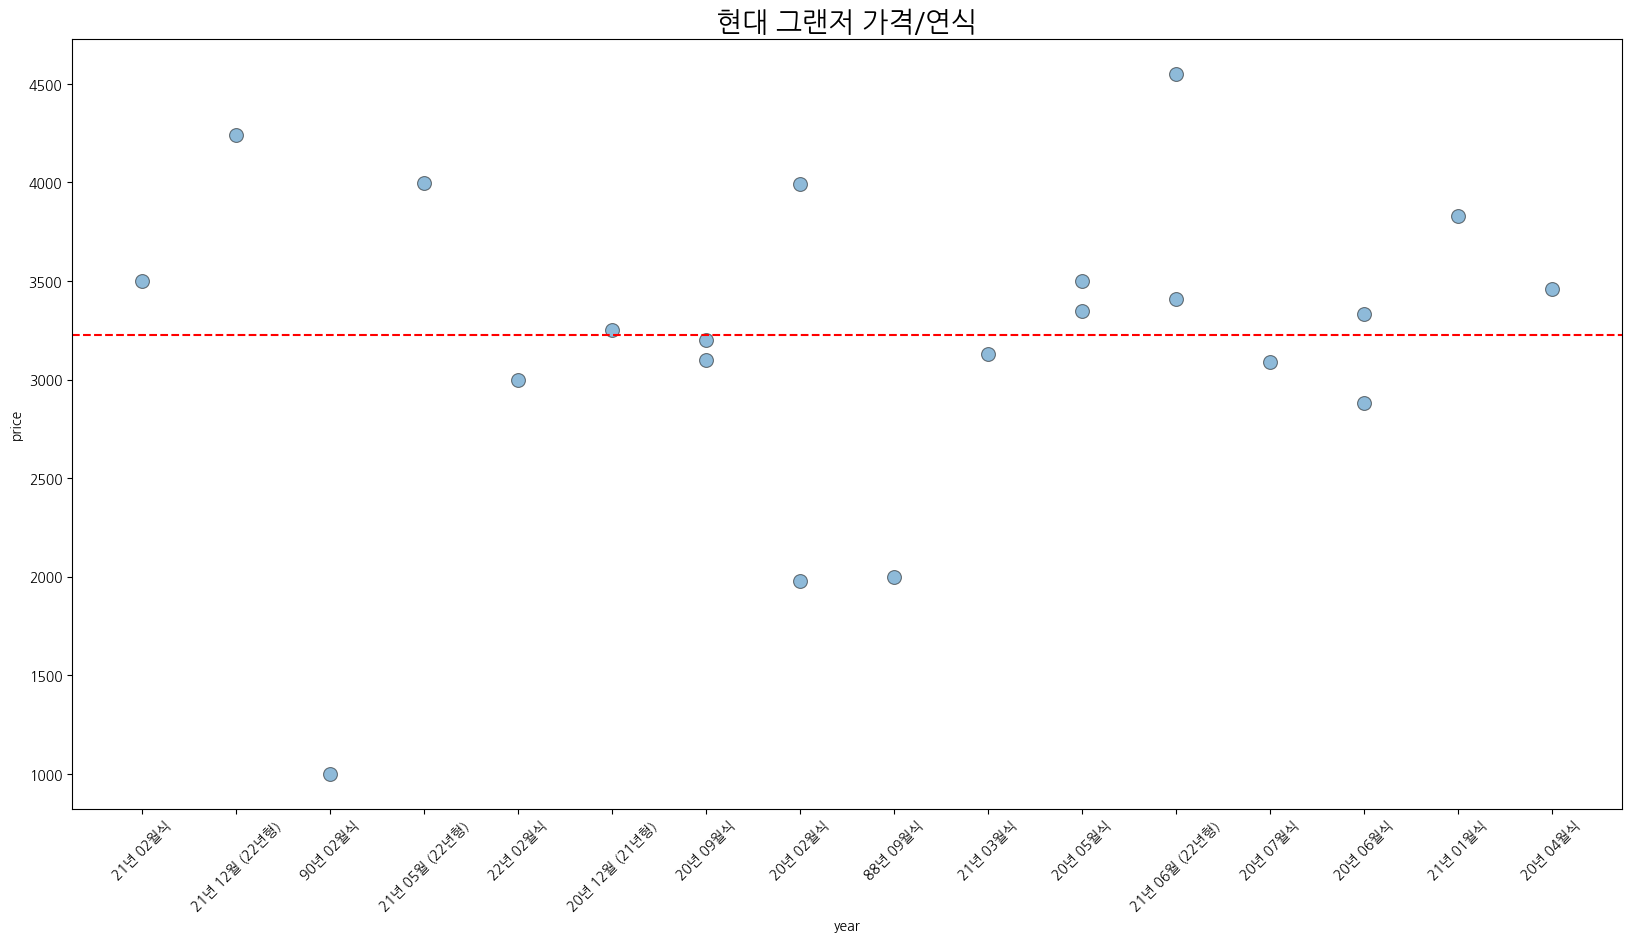

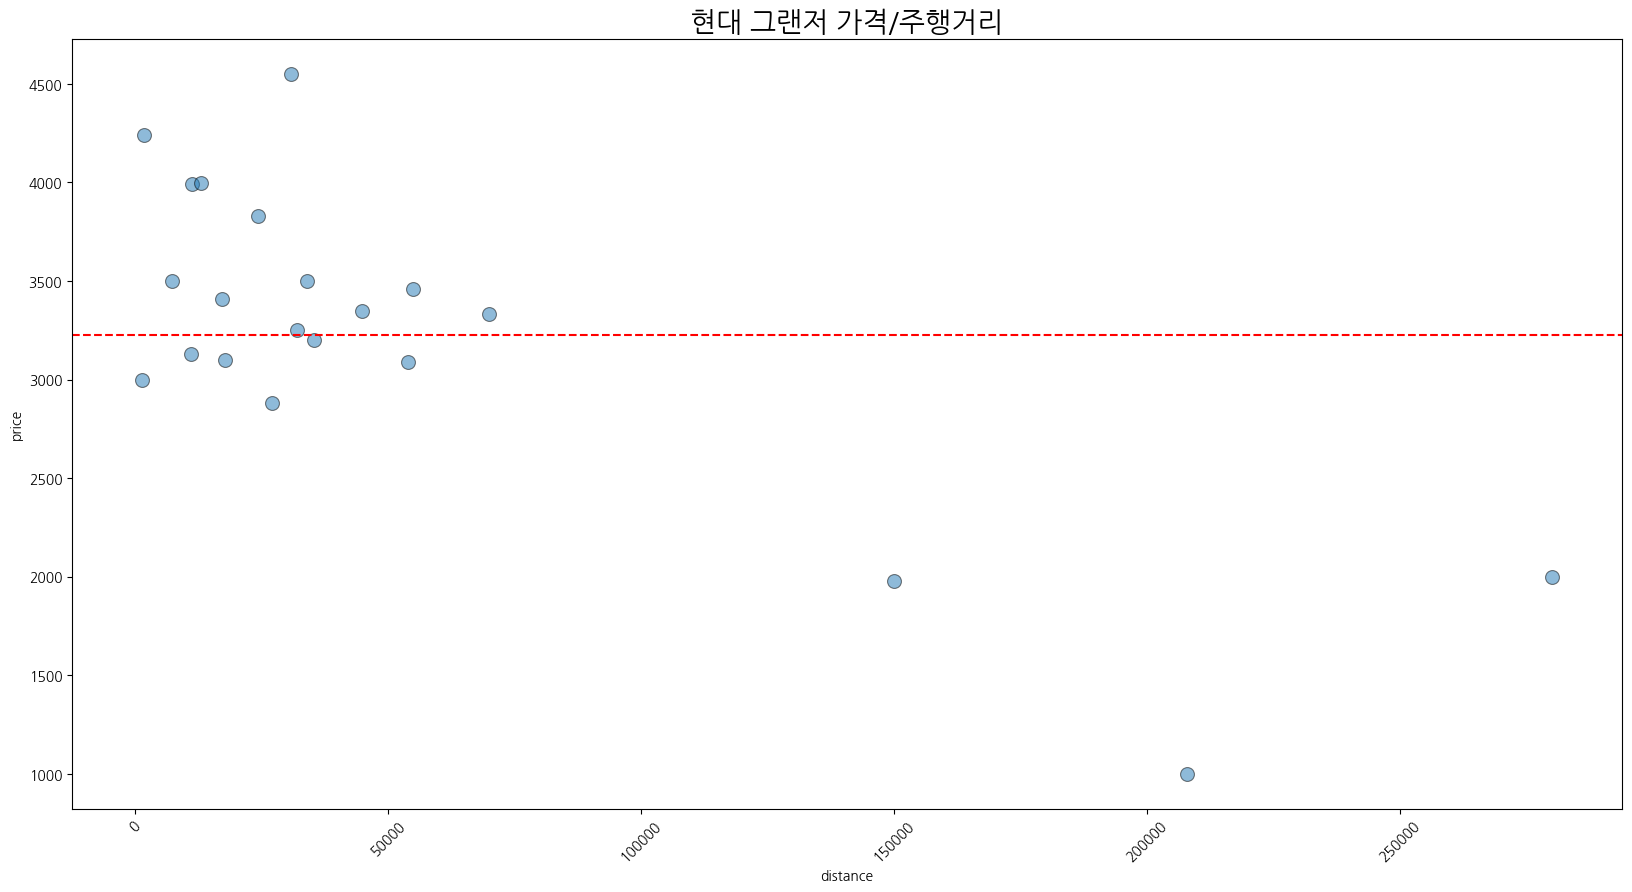

In [311]:

## df_hyundai year price를 그래프로 그리기
plt.figure(figsize=(20, 10))
sns.scatterplot(x=df_hyundai['year'], y= df_hyundai['price'], markers=True, s=100, alpha=0.5, palette='Set2', edgecolor='black')
## df_hyundai['price']의 평균값을 그래프에 표시
plt.axhline(df_hyundai['price'].mean(), color='red', linestyle='--')
## x축 반대로
plt.title('현대 그랜저 가격/연식', fontsize=20)
plt.gca().invert_xaxis()
plt.xticks(rotation=45)    
plt.show()


plt.figure(figsize=(20, 10))
sns.scatterplot(x=df_hyundai['distance'], y=df_hyundai['price'], markers=True, s=100, alpha=0.5, palette='Set2', edgecolor='black')
## df_hyundai['price']의 평균값을 그래프에 표시
plt.axhline(df_hyundai['price'].mean(), color='red', linestyle='--')
plt.title('현대 그랜저 가격/주행거리', fontsize=20)
plt.xticks(rotation=45)
plt.show()